<h1>Мобильные приложения — Выделение групп пользователей на основе поведения</h1>

**Описание проекта:** Мобильное приложение, где пользователи продают и покупают бывшие в употреблении вещи. Размещение объявлений бесплатно. Пользователь платит, если хочет поднять своё объявление в списке рекомендуемых. 

Представлено два датасета:
- с записями (логами) действий пользователей,
- с информацией об источнике, с которого пользователь установил приложение. 

Для разработки стратегии развития продукта, необходимо сегментировать пользователей на основе их поведения в мобильном приложении.

**Задачи проекта:**
- Провести исследовательский анализ данных;
- Сегментировать пользователей на основе их действий;
- Найти aha-moment, позволяющий идентифицировать пользователей, совершающих целевой действие.
- Проверить различие между выделенными пользовательскими сегментами на продуктовых метриках.
- Выдвинуть и проверить гипотезы о различии групп пользователей.

**Описание данных**

Датасет событий содержит следующие признаки:
- время начала события;
- название события;
- уникальный идентификатор пользователя.

Датасет источников привелечения пользователей содержит следующие признаки:
- уникальный идентификатор пользователя;
- источник, с которого пользователь установил приложение.

**Содержание проекта:**

1. [Шаг 1. Откроем файлы с данными и изучим общую информацию](#step1)  
2. [Шаг 2. Предобработка данных](#step2)  
3. [Шаг 3 Исследовательский анализ данных](#step3) 
4. [Шаг 4. Сегментация пользователей](#step4)
5. [Шаг 5. Проверка статистических гипотез](#step5) 
6. [Общие выводы по проекту](#step6)

<h2>Шаг 1. Откроем файлы с данными и изучим общую информацию <a id="step1"></a></h2>

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from numpy import median
import scipy.stats as st
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import math as mth
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

Зададим общий стиль для отрисовки диаграмм в проекте:

In [2]:
plt.style.use('seaborn-darkgrid')

Выведем датасет с данными о действиях пользователей:

In [3]:
events = pd.read_csv('datasets/mobile_dataset.csv')
events.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [4]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


Выведем датасет с данными об источниках загрузки приложения:

In [5]:
sources = pd.read_csv('datasets/mobile_soures.csv')
sources.head()

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [6]:
sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


**Выводы по шагу 1:**
- Датасет events содержит 74197 наблюдений по 3 признакам.
- Датасет sources содержит 4293 наблюдений по 2 признакам.
- Датасеты не содержат пропущенных значений.
- Требуется унификация названий колонок и приведение типов данных в колонке с датой и временем.

<h2>Шаг 2. Предобработка данных<a id="step2"></a></h2>

**Унификация названий колонок**

In [7]:
events.columns = ['event_time', 'event_name', 'user_id']
events.columns

Index(['event_time', 'event_name', 'user_id'], dtype='object')

In [8]:
sources.columns = ['user_id', 'source']
sources.columns 

Index(['user_id', 'source'], dtype='object')

Названия колонок приведены к единому стандарту.

**Приведение типов данных**

Приведём значения колонки events.event_time к типу datetime:

In [9]:
events['event_time'] = pd.to_datetime(events['event_time'], format='%Y-%m-%d %H:%M:%S')
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


In [10]:
events.sample()

,event_time,event_name,user_id
53328,2019-10-27 15:45:40.738222,tips_show,7366cbbb-9546-4f02-8626-a0e597597f0a


Получили формат даты-времени с микросекундами, которые могут сыграть свою роль при дальнейшем анализе.

**Работа с полными дубликатами наблюдений**

In [11]:
events.duplicated().sum()

0

In [12]:
sources.duplicated().sum()

0

Полные дубликаты в датасетах отсутствуют.

**Работа с некорректными и аномальными значениями**

Изучим признаки более подробно: 

In [13]:
events['event_time'].describe()

count                          74197
unique                         74197
top       2019-10-20 20:53:28.313292
freq                               1
first     2019-10-07 00:00:00.431357
last      2019-11-03 23:58:12.532487
Name: event_time, dtype: object

Данные о времени содержат данные за период с 07.10.2019 по 03.11.2019. Благодаря наличию долей секунд, повторов в значениях нет. 74197 записей. Аномалий нет.

Остальные признаки датасетов содержат значения со строковым типом данных, поиск аномалий в которых требует индивидуального подхода.

Изучим уникальные значения названий событий и их количество:

In [14]:
events['event_name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event_name, dtype: int64

Расшифровки событий:
- <span style='color: blue'>advert_open</span> — пользователь открыл карточку объявления;
- <span style='color: blue'>photos_show</span> — пользователь просмотрел фотографии в объявлении;
- <span style='color: blue'>tips_show</span> — пользователь увидел рекомендованные ему объявления;
- <span style='color: blue'>tips_click</span> — пользователь кликнул по рекомендованному объявлению;
- <span style='color: blue'>contacts_show</span> и <span style='color: blue'>show_contacts</span> — пользователь нажал на кнопку просмотра контакта продавца на карточке объявления;
- <span style='color: blue'>contacts_call</span> — пользователь позвонил продавцу, кликнув по номеру телефона, указанному в карточке объявления;
- <span style='color: blue'>map</span> — пользователь открыл карту размещенных объявлений;
- <span style='color: blue'>search_1</span> — <span style='color: blue'>search_7</span> — пользователь осуществляет разные события, связанные с поиском по сайту;
- <span style='color: blue'>favorites_add</span> — пользователь добавил объявление в избранное.

Список не содержит посторонних событий, не свойственных действиям пользователей мобильного приложения: аномалий нет. Однако, в значениях присутствуют 'contacts_show' и 'show_contacts', которые, по информации от заказчика, несут одинаковую смысловую нагрузку. Заменим малочисленное 'show_contacts' на 'contacts_show':

In [15]:
events['event_name'] = events['event_name'].replace('show_contacts', 'contacts_show')
events['event_name'].value_counts()  #Проверим результат

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4529
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
Name: event_name, dtype: int64

Замена прошла успешно.

Изучим значения колонки events.user_id, которые имеют строковый тип данных. Идентификатор пользователя может принимать любые значения. Но, возможно, они стандартизированы по длине. Проверим это, поместив длину значений в отдельную колонку:

In [16]:
events['user_id_length'] = events['user_id'].map(lambda x: len(x))
events.head()

,event_time,event_name,user_id,user_id_length
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,36
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,36
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,36
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,36
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,36


Определим перечень уникальных значений:

In [17]:
events['user_id_length'].unique()

array([36], dtype=int64)

Все значения user_id имеют длину 36 символов. Аномалии отсутствуют. 

Удлим вспомогательный столбец:

In [18]:
events = events.drop('user_id_length', axis=1)

Аналогично проверим значения user_id в датасете sources:

In [19]:
sources['user_id_length'] = sources['user_id'].map(lambda x: len(x)) #Считаем длину строковых значений
sources['user_id_length'].unique() #Определяем список уникальных значений в колонке с длиной значений

array([36], dtype=int64)

Все значения user_id также имеют длину 36 символов. Аномалии отсутствуют.

Удлим вспомогательный столбец:

In [20]:
sources = sources.drop('user_id_length', axis=1)

Посмотрим на значения колонки с источниками:

In [21]:
sources['source'].value_counts()

yandex    1934
other     1230
google    1129
Name: source, dtype: int64

Всего три значения. Все они корректны (имеют смысл в данном контексте). Аномалий нет

Изучение выбросов на данном этапе затруднительно в связи с отсутствием числовых переменных. Мы имеем дело, в основном, с категориальными переменными, распределение которых будет подробнее рассмотрено на этапе исследовательского анализа.

Таким образом, можно констатировать, что в исходных датасетах на данный момент некорректных значений или аномалий нет.

**Выводы по шагу 2:**
- Проведена унификация названий колонок.
- Приведён в соответстие тип значений в колонке с датой-временем.
- Пропуски и аномалии отсутствуют.
- Данные подготовлены для дальнейшего анализа.

<h2>Шаг 3. Исследовательский анализ данных<a id="step3"></a></h2>

**Объединение данных**

Соединим имеющиеся датасеты:

In [22]:
events_data = events.merge(sources, on='user_id', how='left')
events_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
 3   source      74197 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.8+ MB


После соединения размер общего датасета не увеличился по отношению к базовому events, отсутствующие значения не появились. Соединение прошло успешно.

In [23]:
events_data.head()

,event_time,event_name,user_id,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex


Добавим колонку с днём события:

In [24]:
events_data['event_date'] = events_data['event_time'].dt.date
events_data.head()

,event_time,event_name,user_id,source,event_date
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07


**Распределение событий каждого типа**

Определим популярность событий у пользователей:

In [25]:
events_total_count = events_data.groupby('event_name')\
                    .agg({'user_id': 'count'}).reset_index().sort_values('user_id', ascending=False) #Группируем, сортируем
events_total_count = events_total_count.rename(columns={'user_id': 'events_count'}) #Меняем нахвание колонки на понятное
events_total_count

,event_name,events_count
14,tips_show,40055
5,photos_show,10012
0,advert_open,6164
2,contacts_show,4529
4,map,3881
6,search_1,3506
3,favorites_add,1417
10,search_5,1049
13,tips_click,814
9,search_4,701


Представим данные визуально:

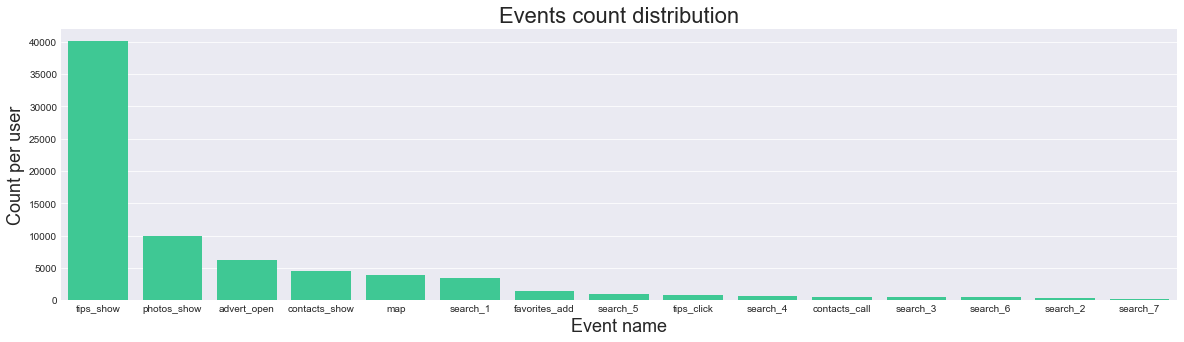

In [26]:
fig, ax = plt.subplots()
fig.set_figheight(5)          
fig.set_figwidth(20)
sns.barplot(data=events_total_count, x='event_name', y='events_count', color='#28df99', estimator=sum)
plt.title('Events count distribution', fontsize=22)
plt.xlabel('Event name', fontsize=18)
plt.ylabel('Count per user', fontsize=18)
plt.show();

Самыми популярными событиями являются показ рекомендованных объявлений, просмотр фотографий, открытие карточки объявления и нажатие на кнопку "показать контакты". Также с заметным отрывом по популярности от остальных событий идут просмотр карты размещённых объявлений и поисковое событие search_1.

Изучим распределения количества событий, совершённых каждым пользователем:

In [27]:
events_per_user = events.groupby('user_id')['event_name'].value_counts()  #количество событий каждого типа на пользователя
events_per_user.name = 'events_count'  #Меняем название Series
events_per_user = events_per_user.reset_index().pivot_table(index='user_id', 
                                                            columns='event_name', 
                                                            values='events_count', 
                                                            aggfunc='sum') #Разносим события по отдельным колонкам
events_per_user.head(2)

event_name,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,tips_click,tips_show
user_id,,,,,,,,,,,,,,,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0
00157779-810c-4498-9e05-a1e9e3cedf93,2.0,5.0,11.0,2.0,NaN,33.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Отсутствующие значения фактически являются нулями, т.к. говорят о том, что данный пользователь не производил данного действия (события). Заменим их нулями:

In [28]:
events_per_user = events_per_user.fillna(0)
events_per_user.head(2)

event_name,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,tips_click,tips_show
user_id,,,,,,,,,,,,,,,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0
00157779-810c-4498-9e05-a1e9e3cedf93,2.0,5.0,11.0,2.0,0.0,33.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Посмотрим на распределения визуально. 

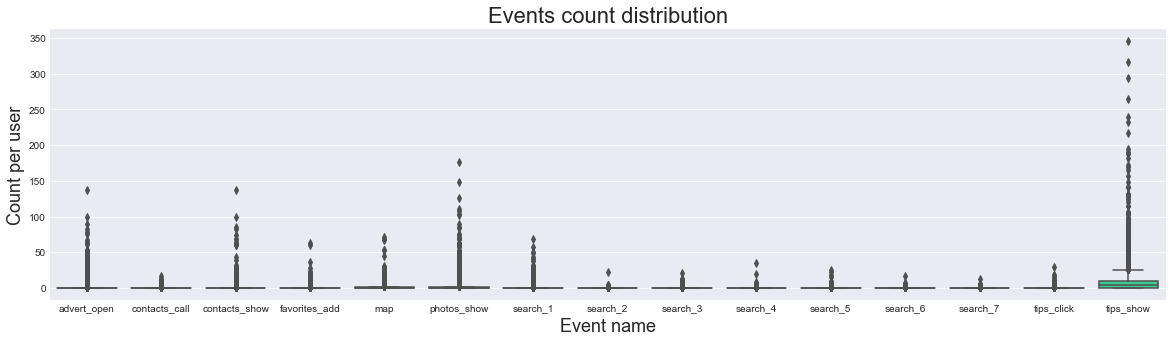

In [29]:
fig, ax = plt.subplots()
fig.set_figheight(5)          
fig.set_figwidth(20)
sns.boxplot(data=events_per_user, color='#28df99')
plt.title('Events count distribution', fontsize=22)
plt.xlabel('Event name', fontsize=18)
plt.ylabel('Count per user', fontsize=18);
plt.show();

На графике видно, что самый большой диапазон значений и выбросов у события "пользователь увидел рекомендованные объявления" (tips_show) На втором месте просмотр фотографий в объявлениях (photos_show). Это закономерно, если исходить из того, что данные события являются первичными этапами взаимодействия с пользователями. Их количество и разброс вызваны тем, что в выборке находятся пользователи, скачавшие приложение в разное время: у самых ранних больше накопленных событий.

Чтобы избежать эффекта накопленных событий, посчитаем для каждого пользователя среднее количество событий в день (с разделением по типу события).

Сначала посчитаем количество событий, которые совершает каждый пользователь в день, когда он был активен:

In [30]:
users_events = events_data.groupby(['user_id', 'event_name', 'event_date'])\
                                    .agg({'event_time': 'count'}).reset_index()
users_events = users_events.rename(columns={'event_time': 'events_count'})
users_events.head()

,user_id,event_name,event_date,events_count
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,map,2019-10-09,2
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,map,2019-10-21,2
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,map,2019-10-22,2
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,2019-10-07,9
4,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,2019-10-09,2


Далее считаем для каждого пользователя количество дней, в которые происходили его события, и количество самих событий (с разделением по типу событий):

In [31]:
users_events_per_day = users_events.groupby(['user_id', 'event_name'])\
                                    .agg({'event_date': 'count', 'events_count': 'sum'}).reset_index()
users_events_per_day = users_events_per_day.rename(columns={'event_date': 'days_count'})
users_events_per_day.head()

,user_id,event_name,days_count,events_count
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,map,3,6
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,4,29
2,00157779-810c-4498-9e05-a1e9e3cedf93,advert_open,2,2
3,00157779-810c-4498-9e05-a1e9e3cedf93,contacts_call,2,5
4,00157779-810c-4498-9e05-a1e9e3cedf93,contacts_show,4,11


Добавляем колонку со средним количеством событий в день:

In [32]:
users_events_per_day['events_per_day'] = (users_events_per_day['events_count'] / users_events_per_day['days_count'])
users_events_per_day.head()

,user_id,event_name,days_count,events_count,events_per_day
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,map,3,6,2.00
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,4,29,7.25
2,00157779-810c-4498-9e05-a1e9e3cedf93,advert_open,2,2,1.00
3,00157779-810c-4498-9e05-a1e9e3cedf93,contacts_call,2,5,2.50
4,00157779-810c-4498-9e05-a1e9e3cedf93,contacts_show,4,11,2.75


In [33]:
users = users_events_per_day.pivot_table(index='user_id', columns='event_name', values='events_per_day', aggfunc='sum')
users.head(2)

event_name,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,tips_click,tips_show
user_id,,,,,,,,,,,,,,,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.25
00157779-810c-4498-9e05-a1e9e3cedf93,1.0,2.5,2.75,1.0,NaN,6.6,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Заменим отсутствующие значения нулями:

In [34]:
users = users.fillna(0)
users.head(2)

event_name,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,tips_click,tips_show
user_id,,,,,,,,,,,,,,,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.0,0.0,0.00,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.25
00157779-810c-4498-9e05-a1e9e3cedf93,1.0,2.5,2.75,1.0,0.0,6.6,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


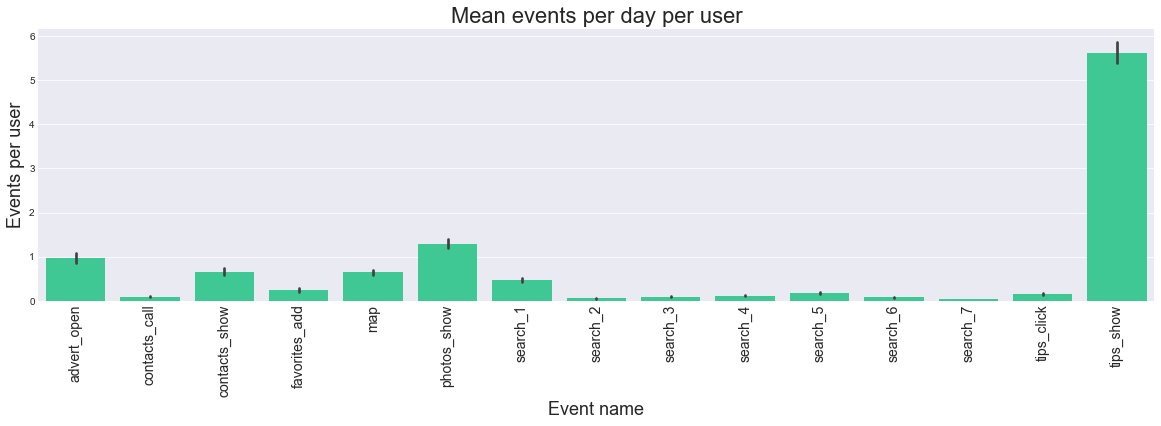

In [35]:
fig, ax = plt.subplots()
fig.set_figheight(5)          
fig.set_figwidth(20)
sns.barplot(data=users, color='#28df99')
plt.title('Mean events per day per user', fontsize=22)
plt.xlabel('Event name', fontsize=18)
plt.ylabel('Events per user', fontsize=18)
plt.xticks(rotation=90, fontsize=14)
plt.show();

В среднем, наиболее частые события - это просмотр рекомендованных объявлений, затем просмотр фотографий в объявлениях, затем открытие объявления.

Посмотрим распределения отдельно по каждому типу события. Для этого подготовим функцию:

In [36]:
def create_boxplot(data, y, figwidth, figheight, title, xlabel, ylabel, orient):
    '''
    Функция строит диаграмму boxplot по входящим данным:
    data - название датафрейма, по данным которого строится диаграмма (df);
    y - название столбца с данными для оси Y (str)
    figheight - высота холста диаграммы (int)
    figwidth - длина холста диаграммы (int)
    title - название диаграммы (str)
    xlabel - название оси Х (str)
    ylabel - название оси Y (str)
    orient - направление расположения диаграммы ('h' - горизонтальное, 'v'- вертикальное) (str)
    '''
    fig, ax = plt.subplots()
    fig.set_figheight(figheight)          
    fig.set_figwidth(figwidth)
    
    if orient=='h':
        sns.boxplot(data=data, y=y, color='#28df99', orient=orient)
        plt.xlabel(xlabel, fontsize=18)
        plt.ylabel(ylabel, fontsize=18)
    else:
        sns.boxplot(data=data, y=y, color='#28df99')
        plt.xlabel(ylabel, fontsize=18)
        plt.ylabel(xlabel, fontsize=18)
        
    plt.title(title, fontsize=22)
    plt.show()

Построим диаграммы распределения:

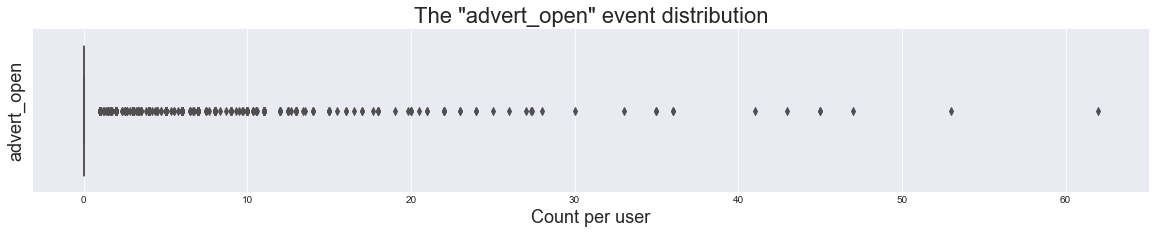

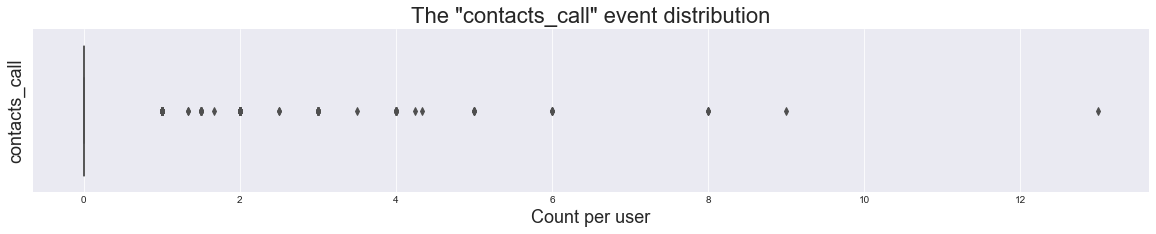

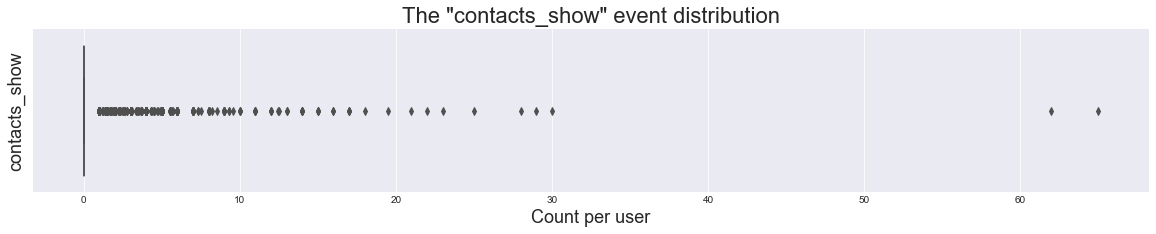

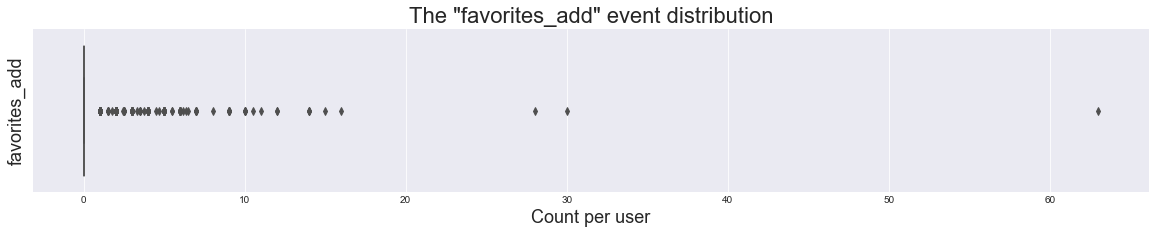

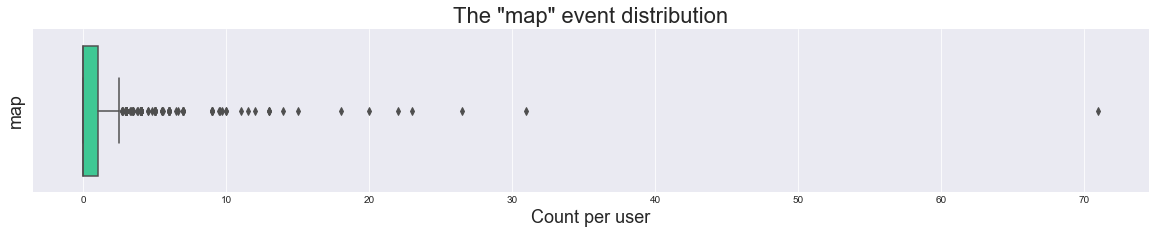

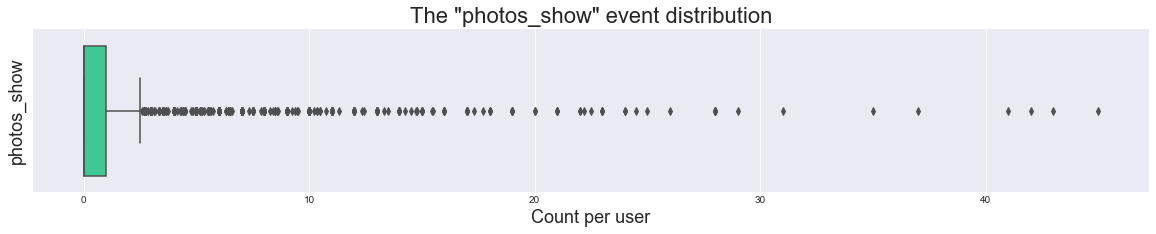

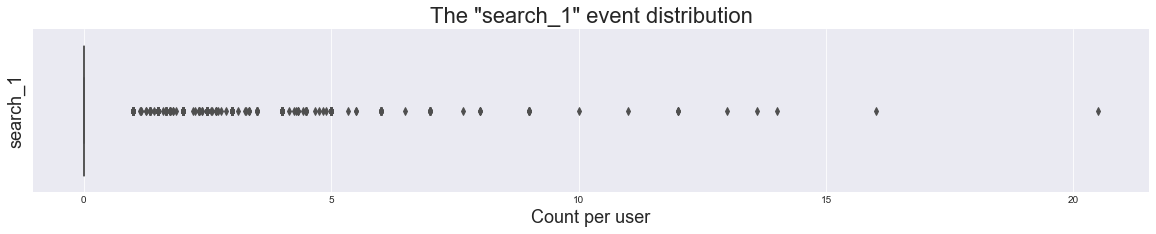

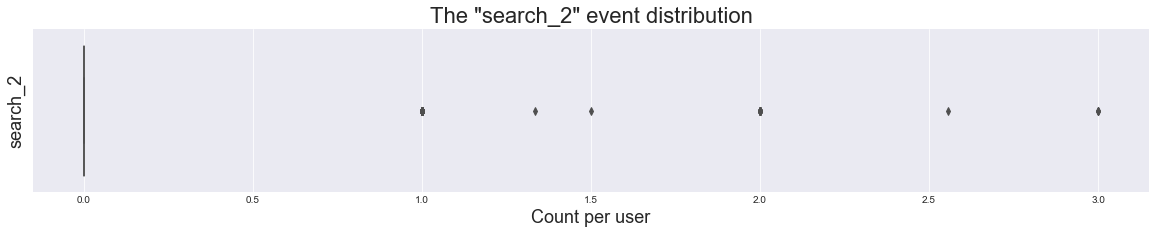

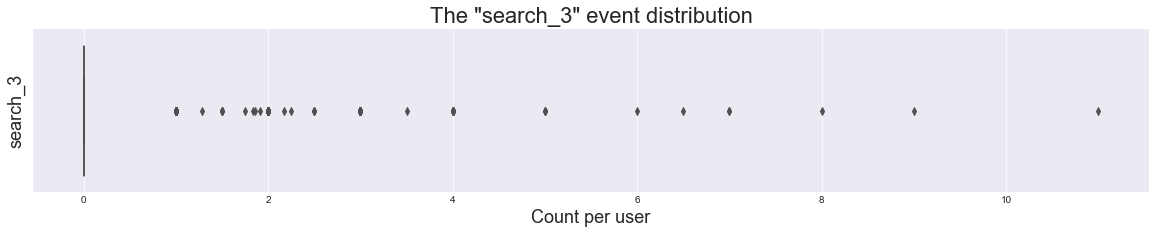

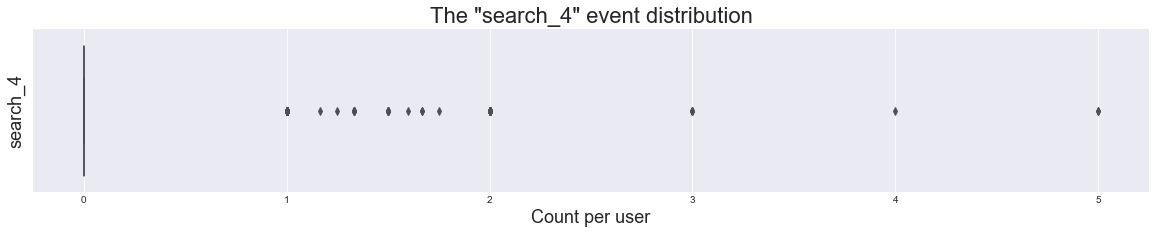

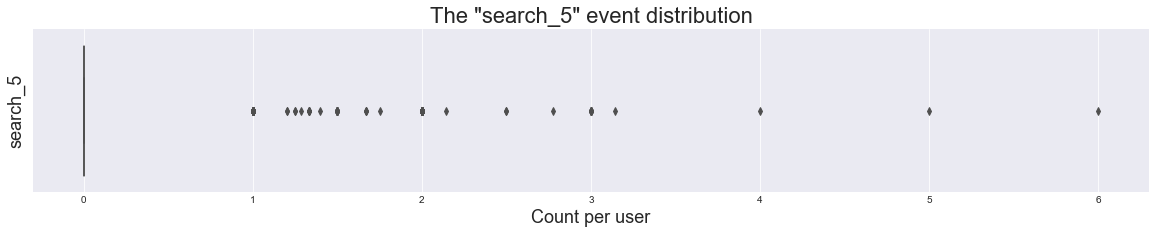

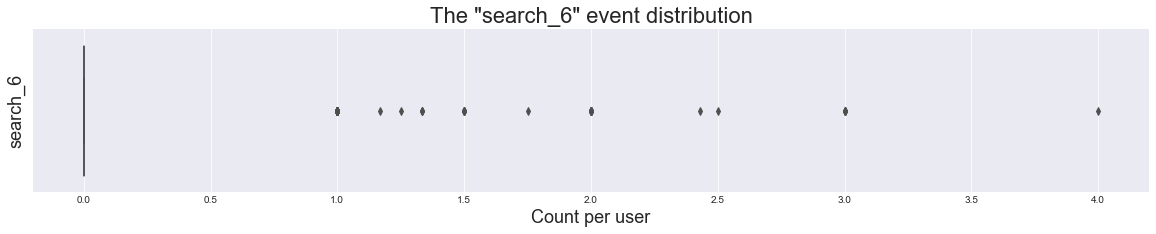

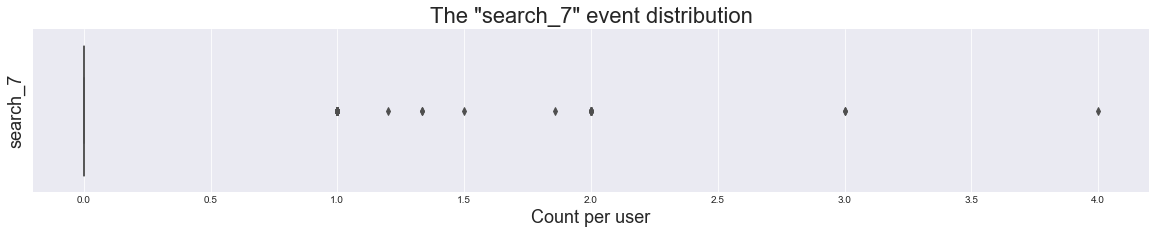

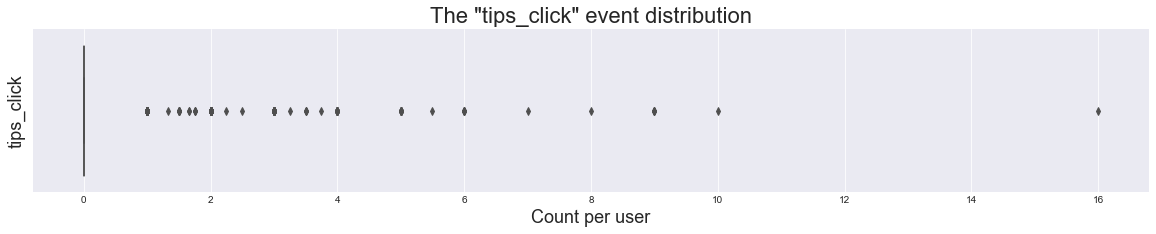

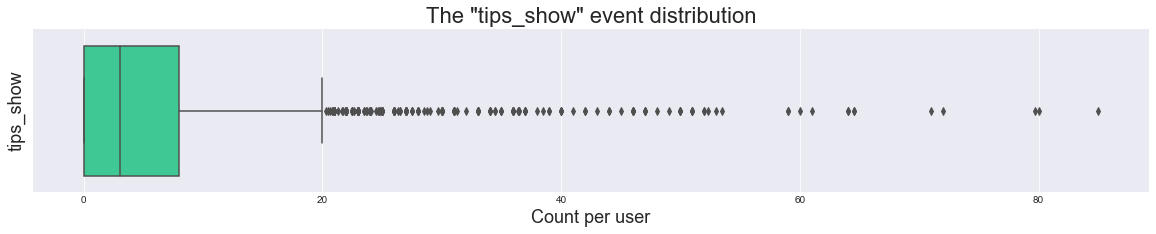

In [37]:
for column in users.columns:
    title = 'The "{}" event distribution'.format(column)
    create_boxplot(users, column, 20, 3, title, 'Count per user', column, 'h')

Как минимум 75% пользователей не практикуют 12 из 18 типов событий (3 квартиль равен нулю). У остальных событий распределение количества просмотров более вариативно, благодаря чему можно реконструировать основной начальный паттерн поведения пользователей: 
1. просмотр списка рекомендованных объявлений;
2. просмотра фотографий в объявлениях;
3. просмотр карты размещённых объявлений.

Для определения количества и доли выбросов в распределениях признаков, создадим функцию: 

In [38]:
def find_users_with_outliers_count(column):
    '''
    Функция принимает колонку из датасета и возвращает количество и долю пользователей 
    с количеством событий, попавших в "верхние" выбросы.
    '''
    quartiles = np.quantile(events_per_user[column], [0.25, 0.75]) #Находим значения 1-го и 3-го квартилей
    normal_values_top_threshold = quartiles[1] + (quartiles[1] - quartiles[0]) * 1.5 #Определяем порог выбросов
    extra_users_count = events_per_user[events_per_user[column]>normal_values_top_threshold].shape[0] #Количество выбросов
    extra_users_share = extra_users_count / events_per_user.shape[0]  #Доля выбросов
    
    return {
        'event_name': column,
        'extra_users_count': extra_users_count, 
        'extra_users_share': extra_users_share
    }

Определим выбросы:

In [39]:
for column in users.columns:
    print(find_users_with_outliers_count(column))

{'event_name': 'advert_open', 'extra_users_count': 751, 'extra_users_share': 0.17493594223153972}
{'event_name': 'contacts_call', 'extra_users_count': 213, 'extra_users_share': 0.0496156533892383}
{'event_name': 'contacts_show', 'extra_users_count': 981, 'extra_users_share': 0.22851153039832284}
{'event_name': 'favorites_add', 'extra_users_count': 351, 'extra_users_share': 0.08176100628930817}
{'event_name': 'map', 'extra_users_count': 392, 'extra_users_share': 0.09131143722338692}
{'event_name': 'photos_show', 'extra_users_count': 838, 'extra_users_share': 0.19520149079897509}
{'event_name': 'search_1', 'extra_users_count': 787, 'extra_users_share': 0.18332168646634056}
{'event_name': 'search_2', 'extra_users_count': 242, 'extra_users_share': 0.056370836245050085}
{'event_name': 'search_3', 'extra_users_count': 208, 'extra_users_share': 0.0484509666899604}
{'event_name': 'search_4', 'extra_users_count': 474, 'extra_users_share': 0.11041229909154437}
{'event_name': 'search_5', 'extra_u

Наибольшая доля выбросов (23%) у события "просмотр контактов". По диаграммам распределения выше мы видели, что 75% пользователей не практикуют это событие. Однако, мы понимаем, что данное событие является "водоразделом" между теми, кто не намерен осуществлять покупку, и теми, кто планирует это сделать, т.к. для покупки "ненужной вещи" требуется знать контакты продавца.

Соответственно, можно сделать вывод о том, что данные 23% пользователей, совершивших хотя бы одно событие "просмотр контактов" и формально попавших в категорию выбросов, не являются выбросами, а могут представлять для исследования максимальный интерес.

Базируясь на этом выводе, можно предположить:
1. что выбросы по остальным типам событий также представляют интерес для исследования. Поэтому на данном этапе необходимо воздержаться от удаления выбросов;
2. что 23% пользователей, совершивших хотя бы одно событие 'contacts_show', можно отнести к группе перспективных пользователей, в связи с чем необходимо изучить их отличительные особенности по сравнению с остальной аудиторией. 

Также интересно распределение события 'advert_open'. Согласно диаграмме barplot, представленной выше, в среднем оно совершается каждым пользователем около 1 раза в день. Однако, по диаграмме boxplot распределения этого признака мы видим, что только 17,5% пользователей, в среднем совершают более одного открытия объявления. По характеру распределения на диаграмме можно заметить, что большая часть из этих 17,5% пользователей, в среднем, открывают от 1 до 10 раз в день.  Обратим внимание в дальнейшем анализе на это событие, в контексте изучения аудитории, практикующей событие 'contacts_show'.

**Разделение событий по сессиям**

In [40]:
events_data.head()

,event_time,event_name,user_id,source,event_date
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07


Для разделения событий по сессиям необходимо:
1. определить последовательности событий для каждого пользователя;
2. определить временные промежутки между событиями;
3. изучить распределение этих временных промежутков;
4. выделить самые длительные временные промежутки;
5. установить критерий длительности, который является временным промежутком между сессиями. 

Определим последовательности событий для каждого пользователя. Для исследования создадим отдельный датафрейм - копию events:

In [41]:
sessions = events.copy()

Отсортируем данные по пользователям и времени события (по возрастанию):

In [42]:
sessions = sessions.sort_values(by=['user_id', 'event_time']).reset_index(drop=True)

Создадим колонку с временем следующего события (находящегося в следующей строке):

In [43]:
sessions['next_event_time'] = sessions['event_time'].shift(-1)

Создадим колонку с user_id, находящимся в следующей строке:

In [44]:
sessions['next_user_id'] = sessions['user_id'].shift(-1)

Получили датафрейм, в котором пользователи идут по порядку. У каждого пользователя даты событий идут по возрастанию. В колонке следующего события next_event_time при переходе от одного пользователя к другому находится дата события другого пользователя. Нам это не подходит. Сделаем так, чтобы если значение next_event_time не принадлежит к данному пользователю, то будем брать значение даты-времени начала события из колонки event_time:

In [45]:
sessions['next_event_time'] = sessions.apply(lambda row: row['event_time'] 
                                                        if row['next_user_id']!=row['user_id']
                                                        else row['next_event_time'], axis=1)
sessions[33:38]

,event_time,event_name,user_id,next_event_time,next_user_id
33,2019-10-22 11:30:05.522265,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22 11:30:52.807203,0001b1d5-b74a-4cbf-aeb0-7df5947bf349
34,2019-10-22 11:30:52.807203,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22 11:30:52.807203,00157779-810c-4498-9e05-a1e9e3cedf93
35,2019-10-19 21:34:33.849769,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:35:19.296599,00157779-810c-4498-9e05-a1e9e3cedf93
36,2019-10-19 21:35:19.296599,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:36:44.344691,00157779-810c-4498-9e05-a1e9e3cedf93
37,2019-10-19 21:36:44.344691,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:40:38.990477,00157779-810c-4498-9e05-a1e9e3cedf93


Избавимся от служебной колонки next_user_id:

In [46]:
sessions = sessions.drop('next_user_id', axis=1)
sessions.head()

,event_time,event_name,user_id,next_event_time
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:40:31.052909
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:41:05.722489
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:43:20.735461
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:45:30.917502
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:45:43.212340


Добавим колонку с датой события:

In [47]:
sessions['event_date'] = sessions['event_time'].dt.date
sessions.head()

,event_time,event_name,user_id,next_event_time,event_date
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:40:31.052909,2019-10-07
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:41:05.722489,2019-10-07
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:43:20.735461,2019-10-07
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:45:30.917502,2019-10-07
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:45:43.212340,2019-10-07


Найдём временные разрывы между началом событий и поместим их в отдельный столбец:

In [48]:
sessions['gap_time_minutes'] = ((sessions['next_event_time'] - sessions['event_time']) 
                                        / np.timedelta64(1,'m')) #временной разрыв в минутах
sessions.head()

,event_time,event_name,user_id,next_event_time,event_date,gap_time_minutes
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:40:31.052909,2019-10-07,0.751059
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:41:05.722489,2019-10-07,0.577826
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:43:20.735461,2019-10-07,2.250216
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:45:30.917502,2019-10-07,2.169701
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:45:43.212340,2019-10-07,0.204914


Каждый тип события имеет свою специфику. Например, просмотр фотографий может занимать гораздо больше времени, чем период от нажатия на кнопку "Показать контакты" до звонка продавцу. Поэтому рассмотрим каждый тип события отдельно в разрезе медианных значений промежутков между данным и следующим событиями по каждому пользователю:

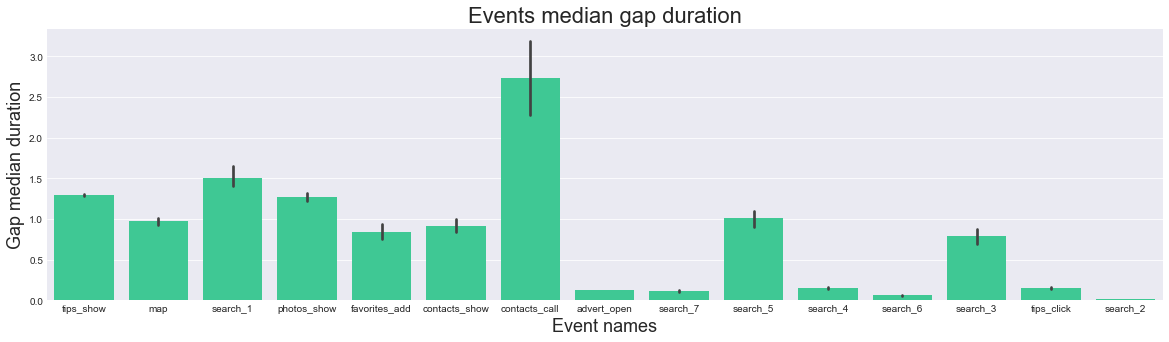

In [49]:
plt.figure(figsize=(20, 5))
sns.barplot(data=sessions, x='event_name', y='gap_time_minutes', estimator=median, color='#28df99')
plt.title('Events median gap duration', fontsize=22)
plt.xlabel('Event names', fontsize=18)
plt.ylabel('Gap median duration', fontsize=18)
plt.show()

Большинство промежутков между событиями имеет длительность менее полутора минут. Наибольшую длительность имеют звонки по контактному номеру в объявлении. Изучим каждый тип события подробнее:

In [50]:
for event, event_slice in sessions.groupby('event_name'):
    print('Event "{}"'.format(event))
    print('95-th percentile equal {:.2f} minutes'.format(np.percentile(event_slice['gap_time_minutes'], 95)))
    display(event_slice.describe().T)
    print()
    print()

Event "advert_open"
95-th percentile equal 5.17 minutes


,count,mean,std,min,25%,50%,75%,max
gap_time_minutes,6164.0,87.266256,1087.579584,0.0,0.074588,0.126783,0.428092,31030.902522




Event "contacts_call"
95-th percentile equal 3064.74 minutes


,count,mean,std,min,25%,50%,75%,max
gap_time_minutes,541.0,523.493572,2220.798271,0.0,0.619192,2.730783,20.725302,31052.417619




Event "contacts_show"
95-th percentile equal 861.31 minutes


,count,mean,std,min,25%,50%,75%,max
gap_time_minutes,4529.0,204.698507,1329.829119,0.0,0.105498,0.909578,3.958591,28608.621705




Event "favorites_add"
95-th percentile equal 1260.12 minutes


,count,mean,std,min,25%,50%,75%,max
gap_time_minutes,1417.0,287.404402,1713.110252,0.0,0.269385,0.84507,2.770728,33147.310205




Event "map"
95-th percentile equal 24.25 minutes


,count,mean,std,min,25%,50%,75%,max
gap_time_minutes,3881.0,155.008823,1260.216789,0.0,0.39882,0.975522,2.067756,31772.99975




Event "photos_show"
95-th percentile equal 1508.47 minutes


,count,mean,std,min,25%,50%,75%,max
gap_time_minutes,10012.0,355.707117,1836.690645,0.0,0.275254,1.269443,4.013516,36160.852151




Event "search_1"
95-th percentile equal 2612.73 minutes


,count,mean,std,min,25%,50%,75%,max
gap_time_minutes,3506.0,464.254946,2064.933081,0.0,0.509084,1.506734,5.994155,37551.967266




Event "search_2"
95-th percentile equal 0.21 minutes


,count,mean,std,min,25%,50%,75%,max
gap_time_minutes,324.0,0.122646,0.94956,0.0,0.009618,0.014364,0.020342,14.792825




Event "search_3"
95-th percentile equal 12.33 minutes


,count,mean,std,min,25%,50%,75%,max
gap_time_minutes,522.0,165.545033,1625.612529,0.0,0.398569,0.793608,1.527703,27517.388832




Event "search_4"
95-th percentile equal 1.10 minutes


,count,mean,std,min,25%,50%,75%,max
gap_time_minutes,701.0,16.908374,335.432036,0.0,0.080706,0.154685,0.27196,8716.411839




Event "search_5"
95-th percentile equal 913.29 minutes


,count,mean,std,min,25%,50%,75%,max
gap_time_minutes,1049.0,318.933679,1862.29763,0.0,0.420262,1.01014,3.304734,24568.365399




Event "search_6"
95-th percentile equal 0.32 minutes


,count,mean,std,min,25%,50%,75%,max
gap_time_minutes,460.0,0.562407,5.89802,0.009573,0.036754,0.059556,0.117507,116.052017




Event "search_7"
95-th percentile equal 0.72 minutes


,count,mean,std,min,25%,50%,75%,max
gap_time_minutes,222.0,7.240334,104.134851,0.0,0.058715,0.111785,0.218862,1551.793249




Event "tips_click"
95-th percentile equal 11.26 minutes


,count,mean,std,min,25%,50%,75%,max
gap_time_minutes,814.0,109.401103,1221.394269,0.0,0.081672,0.150411,0.390689,23211.79587




Event "tips_show"
95-th percentile equal 186.75 minutes


,count,mean,std,min,25%,50%,75%,max
gap_time_minutes,40055.0,195.210349,1417.571793,0.0,0.548335,1.296322,2.919815,38269.914225


95% открытий объявлений длятся 5,17 минут, а 75% - около 26 секунд. При этом распределение сильно смещено вправо (среднее значение равно 87 мин) Для визуальной оценки распределения напишем функцию:

In [51]:
def create_boxplot_for_gaps(event_name, x_limit):
    '''
    Функция строит диаграмму boxplot для колонки event_name датасета sessions.
    Принимает параметры:
    event_name - название события (str)
    x_limit - максимальная метка оси Х (int)
    '''
    plt.figure(figsize=(20, 3))
    sns.boxplot(data=sessions.query('event_name==@event_name'), y='gap_time_minutes', color='#28df99', orient='h')
    plt.title('Events {} gap duration'.format(event_name), fontsize=22)
    plt.xlabel('Gap duration', fontsize=18)
    plt.xlim(0, x_limit)
    plt.show()

Изучим распределение длительности промежутков времени от начала события 'advert_open' до следующего события на диапазоне от 0 до 5 минут:

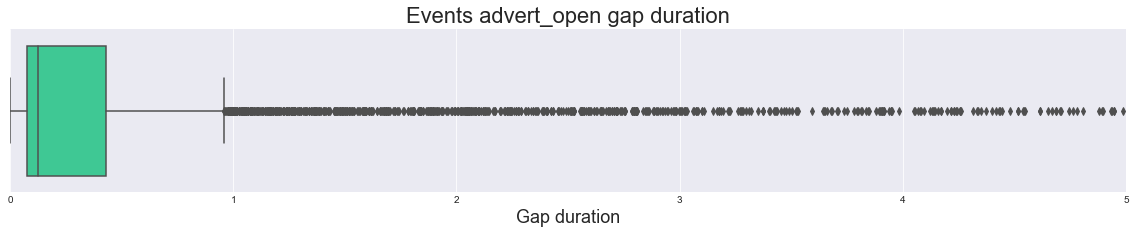

In [52]:
create_boxplot_for_gaps('advert_open', 5)

До 95-го персентиля распределение достаточно плотное. Здравый смысл подсказывает, что длительность 6 минут для события "открытие и просмотр объявления" является достаточной, она охватывает более 95% данных событий.

Создадим словарь ограничений длительности сессий по разным событиям:

In [53]:
session_limits_dict = {'advert_open': 6}

Изучим длительность события 'contacts_call':

In [54]:
np.percentile(sessions.query('event_name=="contacts_call"')['gap_time_minutes'], [55, 60, 65, 70])

array([ 3.3561743 ,  4.09255605,  6.06644528, 11.23374975])

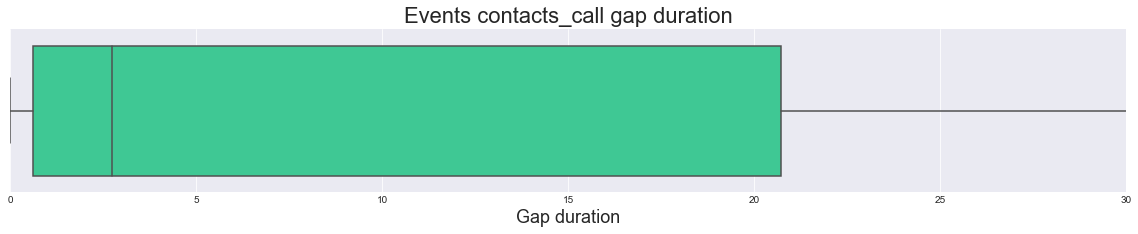

In [55]:
create_boxplot_for_gaps('contacts_call', 30)

Между 65-м и 70-м персентилями происходит резкий скачок в длительности (с 6 до 11 минут). Спецификой события "звонок по объявлению" является высокая вероятность отвлечения пользователя от продолжения взаимодействия с приложением. Поэтому длительность 8 минут представляется достаточной для обсуждения всех нюансов возможной сделки купли-продажи "ненужной вещи". Добавим это в словарь:

In [56]:
session_limits_dict['contacts_call'] = 8

Изучим длительность события "contacts_show":

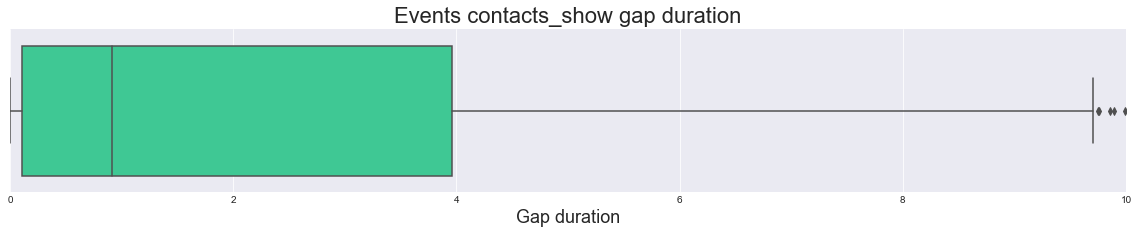

In [57]:
create_boxplot_for_gaps('contacts_show', 10)

Установка лимита продолжительности сессии на уровне 3-го квартиля представляется разумной (4 минуты). Добавим в словарь:

In [58]:
session_limits_dict['contacts_show'] = 4

Изучим длительность события "favorites_add":

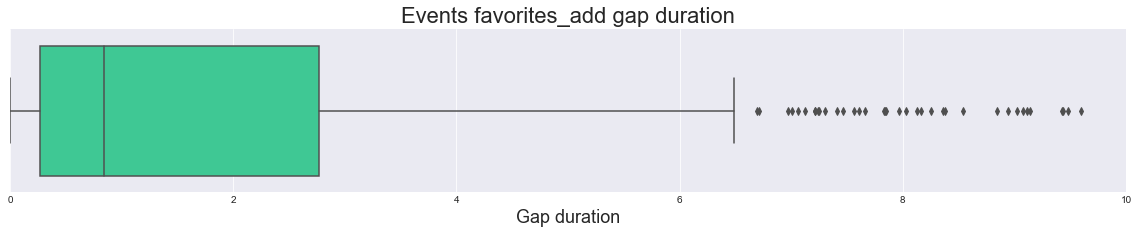

In [59]:
create_boxplot_for_gaps('favorites_add', 10)

Длительность события "добавление в избранное" установим на уровне 3-х минут. Добавим в словарь:

In [60]:
session_limits_dict['favorites_add'] = 3

Изучим длительность события "map":

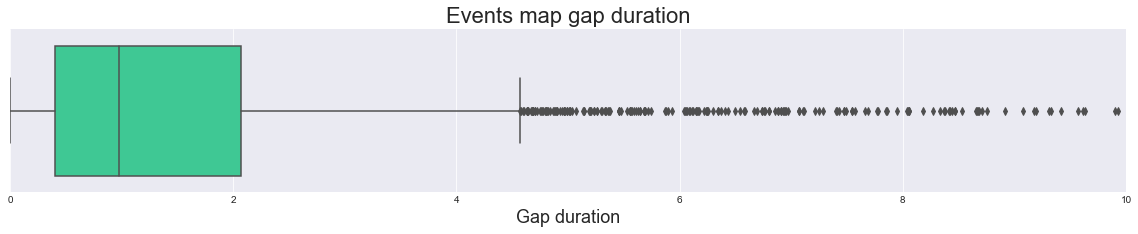

In [61]:
create_boxplot_for_gaps('map', 10)

Лимит длительности для просмотра карты объявлений 3 минуты. Добавим в словарь:

In [62]:
session_limits_dict['map'] = 3

Изучим длительность события "photos_show":

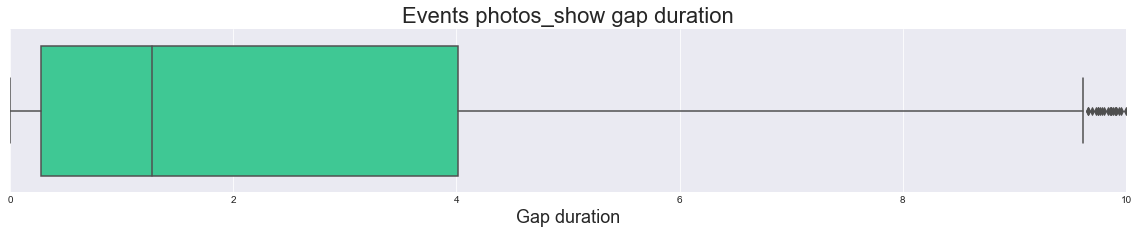

In [63]:
create_boxplot_for_gaps('photos_show', 10)

Просмотр фотографий на протяжении 6 минут представляется достаточным. Добавим лимит в словарь:

In [64]:
session_limits_dict['photos_show'] = 6

Изучим длительность события "search_1":

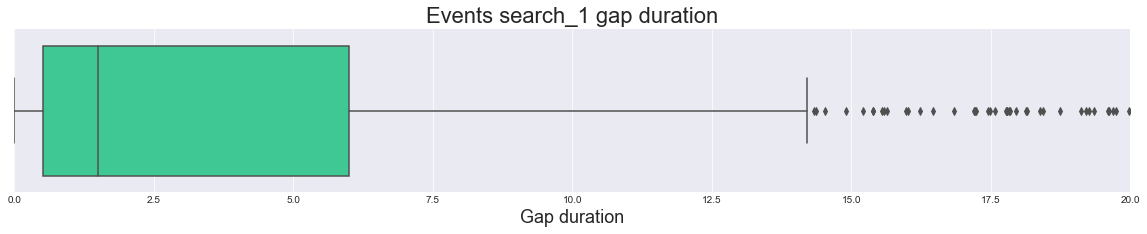

In [65]:
create_boxplot_for_gaps('search_1', 20)

Поисковое событие "search_1" длительностью 10 минут добавим в лимиты:

In [66]:
session_limits_dict['search_1'] = 10

Далее, рассматривая длительность поисковых событий "search_2" - "search_2", добавим соответствующие лимиты в словарь:

In [67]:
session_limits_dict['search_2'] = 0.3
session_limits_dict['search_3'] = 3
session_limits_dict['search_4'] = 1.5
session_limits_dict['search_5'] = 5
session_limits_dict['search_6'] = 0.4
session_limits_dict['search_7'] = 1

Изучим длительность события "tips_click". Добавим лимит в словарь:

In [68]:
session_limits_dict['tips_click'] = 0.5

Изучим длительность события "tips_show". Добавим лимит в словарь:

In [69]:
session_limits_dict['tips_show'] = 3

Посмотрим на сформированный словарь:

In [70]:
session_limits_dict

{'advert_open': 6,
 'contacts_call': 8,
 'contacts_show': 4,
 'favorites_add': 3,
 'map': 3,
 'photos_show': 6,
 'search_1': 10,
 'search_2': 0.3,
 'search_3': 3,
 'search_4': 1.5,
 'search_5': 5,
 'search_6': 0.4,
 'search_7': 1,
 'tips_click': 0.5,
 'tips_show': 3}

Создадим словарь событий, чья длительность превышает установленные выше лимиты. За идентификатор события примем время старта события (они уникальны на всём протяжении датасета):

In [71]:
over_duration_events_dict = {}

В настоящий момент датасет sessions состоит из последовательного перебора всех пользователей, у которых последовательно перебираются все события (от самого первого до последнего). Необходимо разделить события на сессии.

Создадим переменную для накапливания индексов сессий (по умолчанию 1):

In [72]:
sessions_counter = 1

Создадим переменную-маркер смены индекса сессий (0 - не меняем индекс, 1 - меняем индекс):

In [73]:
session_id_change_mark = 0

В цикле проитерируемся по строкам датасета sessions и промаркируем события условными идентификаторами сессий:

In [74]:
for i in range(len(sessions)):
    current_gap = sessions.loc[i, 'gap_time_minutes']
    current_event = sessions.loc[i, 'event_name']
    
    #Если длительность между событиями превышает разрешённый лимит,
    #или маркер переключения индекса сессии говорит о том, что на предыдущей итерации длительность была равна нулю:
    if (current_gap > session_limits_dict[current_event]) or (session_id_change_mark == 1):
        sessions_counter += 1       #Меняем индекс сессии
        sessions.loc[i, 'sessions_ids'] = sessions_counter     #записываем текущее значение индекса сессии
        session_id_change_mark = 0   #на следующей итерации смены индекса сессии не планируется
        
        if (current_gap > session_limits_dict[current_event]):
            key = sessions.loc[i, 'event_time']
            over_duration_events_dict[key] = current_gap  #Добавляем длительность в словарь сверхдлительных событий
        
    elif (current_gap == 0):
        sessions.loc[i, 'sessions_ids'] = sessions_counter
        session_id_change_mark = 1   #меняем отметку смены индекса сессии - на следующей итерации будет смена
        
    else:
        sessions.loc[i, 'sessions_ids'] = sessions_counter
        session_id_change_mark = 0   #на следующей итерации смены индекса сессии не планируется

In [75]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   event_time        74197 non-null  datetime64[ns]
 1   event_name        74197 non-null  object        
 2   user_id           74197 non-null  object        
 3   next_event_time   74197 non-null  datetime64[ns]
 4   event_date        74197 non-null  object        
 5   gap_time_minutes  74197 non-null  float64       
 6   sessions_ids      74197 non-null  float64       
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 4.0+ MB


Получили колонку с маркерами сессий. Однако, в колонке gap_time_minutes у нас содержатся чрезмерные длительности между сессиями. Это нам мешает принять значения этой колонки для расчёта длительности сессий. Найдём такие значения и заменим их на средний показатель для данного типа события для данного пользователя.

Создадим словарь средней длительности событий по типам событий. Для начала сделаем срез датасета без чрезмерных длительностей:

In [76]:
oversized_duration_event_times = over_duration_events_dict.keys() #Положим все ключи словаря over_duration_events_dict в список
sessions_without_oversized_periods = (sessions[~sessions['event_time']
                                                            .isin(oversized_duration_event_times)])
sessions_without_oversized_periods.head()

,event_time,event_name,user_id,next_event_time,event_date,gap_time_minutes,sessions_ids
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:40:31.052909,2019-10-07,0.751059,1.0
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:41:05.722489,2019-10-07,0.577826,1.0
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:43:20.735461,2019-10-07,2.250216,1.0
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:45:30.917502,2019-10-07,2.169701,1.0
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:45:43.212340,2019-10-07,0.204914,1.0


Объявим словарь со значениями средней длительности событий для каждого пользователя:

In [77]:
events_mean_duration_dict = {}

Наполним словарь средними значениями (итеративно используем группировку по пользователям и событиям):

In [78]:
for event, event_slice in sessions_without_oversized_periods.groupby('event_name'):
    current_mean_event_time = event_slice['gap_time_minutes'].mean()
    events_mean_duration_dict[event] = current_mean_event_time

In [79]:
events_mean_duration_dict

{'advert_open': 0.4563752766949638,
 'contacts_call': 1.7490455935967304,
 'contacts_show': 0.8293657775558156,
 'favorites_add': 0.7630951314421895,
 'map': 0.9204770948033115,
 'photos_show': 1.2420135128448249,
 'search_1': 1.7407420726558798,
 'search_2': 0.025197761431623947,
 'search_3': 0.7937110506367041,
 'search_4': 0.21671462970370364,
 'search_5': 1.0703714014570864,
 'search_6': 0.08468699708994708,
 'search_7': 0.16394752736434118,
 'tips_click': 0.15057571684782575,
 'tips_show': 1.0318377387411724}

На данный момент у нас есть словарь событий over_duration_events_dict со значениями длительности, превышающими установленные лимиты, и словарь events_mean_duration_dict, который содержит среднюю длительность событий. Создадим функцию, устанавливающую среднюю длительность события там, где значение в колонке gap_time_minutes датасета sessions превышает лимиты:

In [80]:
def get_mean_session_duration(row):
    event_time = row['event_time']
    user_id = row['user_id']
    event_name = row['event_name']

    if (event_time in over_duration_events_dict.keys()) or (event_time==0):
        return events_mean_duration_dict[event_name]
    
    else:
        return row['gap_time_minutes']

Добавим к датасету sessions колонку с длительностью событий:

In [81]:
sessions['session_duration'] = (sessions.apply(get_mean_session_duration, axis=1)).round(2)
sessions.head()

,event_time,event_name,user_id,next_event_time,event_date,gap_time_minutes,sessions_ids,session_duration
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:40:31.052909,2019-10-07,0.751059,1.0,0.75
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:41:05.722489,2019-10-07,0.577826,1.0,0.58
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:43:20.735461,2019-10-07,2.250216,1.0,2.25
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:45:30.917502,2019-10-07,2.169701,1.0,2.17
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:45:43.212340,2019-10-07,0.204914,1.0,0.20


Теперь мы можем продолжать исследование, получая метрикии в разрезе сессий.

**Количество и средняя длительность сессий для каждого пользователя**

Сделаем группировку по пользователям и сессиям, определим количество событий внутри сессии и длительность сессии:

In [82]:
events_and_sessions = sessions.groupby(['user_id', 'sessions_ids'])\
                                                            .agg({'event_name': 'count', 'session_duration': 'sum'})\
                                                            .reset_index()
#Заменим название колонки event_name на более соответствующее:
events_and_sessions = events_and_sessions.rename(columns={'event_name':'events_count'})
events_and_sessions.head()

,user_id,sessions_ids,events_count,session_duration
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1.0,8,9.93
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2.0,2,2.57
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3.0,2,2.82
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4.0,11,10.39
4,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,5.0,3,3.46


Для каждого пользователя рассчитаем количество сессий, событий и общее время взаимодействия с приложением:

In [83]:
events_and_sessions_grouped_by_users = (events_and_sessions.groupby('user_id')
                                        .agg({'sessions_ids':'count', 'events_count':'sum', 'session_duration':'sum'})
                                        .reset_index())
#Заменим название колонок на более соответствующие:
events_and_sessions_grouped_by_users = events_and_sessions_grouped_by_users.rename(columns={'sessions_ids':'sessions_count', 
                                                          'session_duration':'total_interaction_duration'})

events_and_sessions_grouped_by_users.head()

,user_id,sessions_count,events_count,total_interaction_duration
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,7,35,39.83
1,00157779-810c-4498-9e05-a1e9e3cedf93,13,71,112.65
2,00463033-5717-4bf1-91b4-09183923b9df,2,10,16.97
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,13,32,25.03
4,00551e79-152e-4441-9cf7-565d7eb04090,3,8,12.82


Рассчитаем среднюю длительность сессии для каждого пользователя:

In [84]:
events_and_sessions_grouped_by_users['mean_session_duration'] = (events_and_sessions_grouped_by_users['total_interaction_duration']
                                                            / events_and_sessions_grouped_by_users['sessions_count']).round(2)
events_and_sessions_grouped_by_users.head()

,user_id,sessions_count,events_count,total_interaction_duration,mean_session_duration
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,7,35,39.83,5.69
1,00157779-810c-4498-9e05-a1e9e3cedf93,13,71,112.65,8.67
2,00463033-5717-4bf1-91b4-09183923b9df,2,10,16.97,8.48
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,13,32,25.03,1.93
4,00551e79-152e-4441-9cf7-565d7eb04090,3,8,12.82,4.27


Изучим распределение средней длительности сессий:

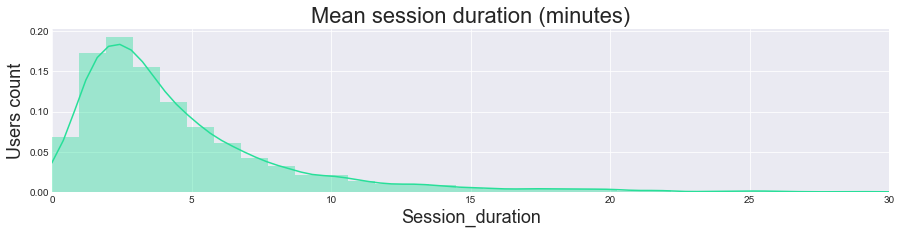

In [85]:
plt.figure(figsize=(15, 3))
sns.distplot(events_and_sessions_grouped_by_users['mean_session_duration'], color='#28df99')
plt.title('Mean session duration (minutes)', fontsize=22)
plt.xlabel('Session_duration', fontsize=18)
plt.ylabel('Users count', fontsize=18)
plt.xlim(0, 30)
plt.show()

Чаще всего длительность сессии составляет порядка 2,5 минут. Однако, для цели данного исследования нам могут быть интересны пользователи с гораздо более длительными сессиями.

**Количество событий на одну сессию**

Для каждого пользователя рассчитаем среднее значение количества совершаемых событий за одну сессию:

In [86]:
events_and_sessions_grouped_by_users['mean_events_count_per_session'] = (events_and_sessions_grouped_by_users['events_count']
                                                            / events_and_sessions_grouped_by_users['sessions_count']).round(2)
events_and_sessions_grouped_by_users.head()

,user_id,sessions_count,events_count,total_interaction_duration,mean_session_duration,mean_events_count_per_session
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,7,35,39.83,5.69,5.00
1,00157779-810c-4498-9e05-a1e9e3cedf93,13,71,112.65,8.67,5.46
2,00463033-5717-4bf1-91b4-09183923b9df,2,10,16.97,8.48,5.00
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,13,32,25.03,1.93,2.46
4,00551e79-152e-4441-9cf7-565d7eb04090,3,8,12.82,4.27,2.67


Посмотрим на распределение медианных значений количества событий на одну сессию:

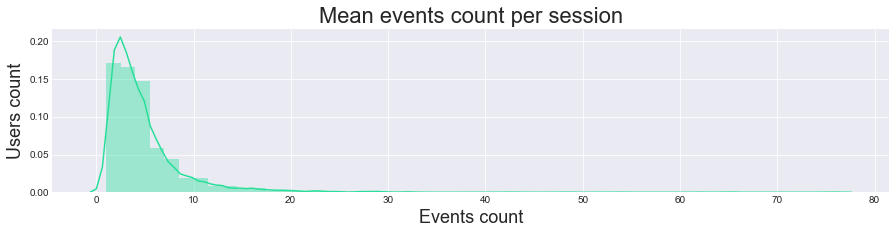

In [87]:
plt.figure(figsize=(15, 3))
sns.distplot(events_and_sessions_grouped_by_users['mean_events_count_per_session'], color='#28df99')
plt.title('Mean events count per session', fontsize=22)
plt.xlabel('Events count', fontsize=18)
plt.ylabel('Users count', fontsize=18)
plt.show()

Наибольшая частотность у пользователей, сессии которых состоят из 4-5 действий-событий. Но мы также можем наблюдать присутствие пользователей с числом событий за сессию от 30 до 78.

Будем собирать пользовательские признаки в датасете users:

In [88]:
users = users.reset_index()
users.head(2)

event_name,user_id,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,tips_click,tips_show
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.0,0.0,0.00,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.25
1,00157779-810c-4498-9e05-a1e9e3cedf93,1.0,2.5,2.75,1.0,0.0,6.6,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


Приведём названия признаков в соответствие смыслу значений:

In [89]:
users.columns = ['user_id', 'advert_open_counts_per_day', 'contacts_call_counts_per_day', 'contacts_show_counts_per_day', 
                 'favorites_add_counts_per_day', 'map_counts_per_day', 'photos_show_counts_per_day', 
                 'search_1_counts_per_day', 'search_2_counts_per_day', 'search_3_counts_per_day', 
                 'search_4_counts_per_day', 'search_5_counts_per_day', 'search_6_counts_per_day', 
                 'search_7_counts_per_day', 'tips_click_counts_per_day', 'tips_show_counts_per_day']

В качестве пользовательских признаков будем собирать относительные характеристики, так как пользователи имеют разный стаж взаимодействия с приложением: абсолютные признаки накапливаются со временем и искажают средние статистики по пользователям.

In [90]:
events_and_sessions_relative_signs = events_and_sessions_grouped_by_users[['user_id', 'mean_session_duration',
                                                                           'mean_events_count_per_session']]
events_and_sessions_relative_signs.head()

,user_id,mean_session_duration,mean_events_count_per_session
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,5.69,5.00
1,00157779-810c-4498-9e05-a1e9e3cedf93,8.67,5.46
2,00463033-5717-4bf1-91b4-09183923b9df,8.48,5.00
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,1.93,2.46
4,00551e79-152e-4441-9cf7-565d7eb04090,4.27,2.67


Соединим пользовательские данные в один датасет:

In [91]:
users = users.merge(events_and_sessions_relative_signs, on='user_id', how='left')
users.head(2)

,user_id,advert_open_counts_per_day,contacts_call_counts_per_day,contacts_show_counts_per_day,favorites_add_counts_per_day,map_counts_per_day,photos_show_counts_per_day,search_1_counts_per_day,search_2_counts_per_day,search_3_counts_per_day,search_4_counts_per_day,search_5_counts_per_day,search_6_counts_per_day,search_7_counts_per_day,tips_click_counts_per_day,tips_show_counts_per_day,mean_session_duration,mean_events_count_per_session
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.0,0.0,0.00,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.25,5.69,5.00
1,00157779-810c-4498-9e05-a1e9e3cedf93,1.0,2.5,2.75,1.0,0.0,6.6,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,8.67,5.46


In [92]:
users.shape[0]

4293

In [93]:
users.isna().sum()

user_id                          0
advert_open_counts_per_day       0
contacts_call_counts_per_day     0
contacts_show_counts_per_day     0
favorites_add_counts_per_day     0
map_counts_per_day               0
photos_show_counts_per_day       0
search_1_counts_per_day          0
search_2_counts_per_day          0
search_3_counts_per_day          0
search_4_counts_per_day          0
search_5_counts_per_day          0
search_6_counts_per_day          0
search_7_counts_per_day          0
tips_click_counts_per_day        0
tips_show_counts_per_day         0
mean_session_duration            0
mean_events_count_per_session    0
dtype: int64

Количество строк в новом датасете соответствует количеству строк исходных таблиц, пропуски отсутствуют. Слияние прошло успешно.

**Количество и длительность сессий на пользователя в день**

Посчитаем количество сессий и длительность активности пользователя на каждый день:

In [94]:
sessions_per_user_per_day = (sessions.groupby(['user_id', 'event_date'])
                             .agg({'sessions_ids': 'count', 'session_duration': 'sum'})
                             .reset_index()
                            )
sessions_per_user_per_day = sessions_per_user_per_day.rename(columns={'sessions_ids': 'sessions_count', 
                                                                      'session_duration': 'activity_duration'})
sessions_per_user_per_day.head()

,user_id,event_date,sessions_count,activity_duration
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,9,10.96
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,4,5.39
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,14,13.85
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22,8,9.63
4,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19,9,16.71


Посчитаем количество дней, в которые пользователь был активен, его общие количество сессий и длительность взаимодействия с приложением:

In [95]:
sessions_per_user_per_day = (sessions_per_user_per_day.groupby('user_id')
                             .agg({'event_date': 'count', 'sessions_count': 'sum', 'activity_duration': 'sum'})
                             .reset_index()
                            )
sessions_per_user_per_day = sessions_per_user_per_day.rename(columns={'event_date': 'days_count'})
sessions_per_user_per_day.head()

,user_id,days_count,sessions_count,activity_duration
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,35,39.83
1,00157779-810c-4498-9e05-a1e9e3cedf93,6,71,112.65
2,00463033-5717-4bf1-91b4-09183923b9df,1,10,16.97
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,6,32,25.03
4,00551e79-152e-4441-9cf7-565d7eb04090,3,8,12.82


Рассчитаем среднее количество сессий в день по каждому пользователю:

In [96]:
sessions_per_user_per_day['sessions_per_day'] = (sessions_per_user_per_day['sessions_count'] 
                                                 / sessions_per_user_per_day['days_count']).round(2)
sessions_per_user_per_day.head()

,user_id,days_count,sessions_count,activity_duration,sessions_per_day
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,35,39.83,8.75
1,00157779-810c-4498-9e05-a1e9e3cedf93,6,71,112.65,11.83
2,00463033-5717-4bf1-91b4-09183923b9df,1,10,16.97,10.00
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,6,32,25.03,5.33
4,00551e79-152e-4441-9cf7-565d7eb04090,3,8,12.82,2.67


Рассчитаем среднюю продолжительность активности в день по каждому пользователю:

In [97]:
sessions_per_user_per_day['activity_duration_per_day'] = (sessions_per_user_per_day['activity_duration'] 
                                                 / sessions_per_user_per_day['days_count']).round(2)
sessions_per_user_per_day.head()

,user_id,days_count,sessions_count,activity_duration,sessions_per_day,activity_duration_per_day
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,35,39.83,8.75,9.96
1,00157779-810c-4498-9e05-a1e9e3cedf93,6,71,112.65,11.83,18.77
2,00463033-5717-4bf1-91b4-09183923b9df,1,10,16.97,10.00,16.97
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,6,32,25.03,5.33,4.17
4,00551e79-152e-4441-9cf7-565d7eb04090,3,8,12.82,2.67,4.27


Посмотрим на распределение средней длительности пользовательского взаимодействия с приложением в течение дня:

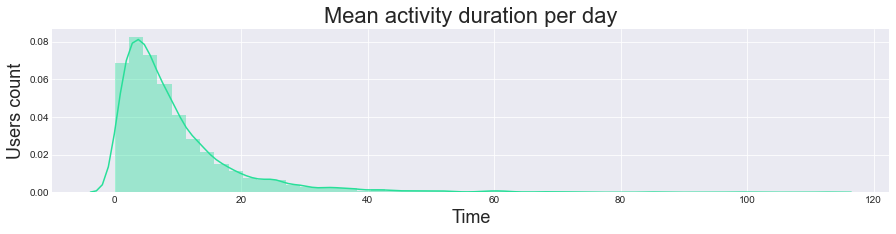

In [98]:
plt.figure(figsize=(15, 3))
sns.distplot(sessions_per_user_per_day['activity_duration_per_day'], color='#28df99')
plt.title('Mean activity duration per day', fontsize=22)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Users count', fontsize=18)
plt.show()

В основном, приложение используется до 10 минут в день.

Добавим пользовательские данные о количестве сессий и продолжительности активности в день в датафрейм users:

In [99]:
sessions_per_user_per_day_for_merge = sessions_per_user_per_day[['user_id', 'sessions_per_day', 'activity_duration_per_day']]

In [100]:
users = users.merge(sessions_per_user_per_day_for_merge, on='user_id', how='left')
users.head(2)

,user_id,advert_open_counts_per_day,contacts_call_counts_per_day,contacts_show_counts_per_day,favorites_add_counts_per_day,map_counts_per_day,photos_show_counts_per_day,search_1_counts_per_day,search_2_counts_per_day,search_3_counts_per_day,search_4_counts_per_day,search_5_counts_per_day,search_6_counts_per_day,search_7_counts_per_day,tips_click_counts_per_day,tips_show_counts_per_day,mean_session_duration,mean_events_count_per_session,sessions_per_day,activity_duration_per_day
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.0,0.0,0.00,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.25,5.69,5.00,8.75,9.96
1,00157779-810c-4498-9e05-a1e9e3cedf93,1.0,2.5,2.75,1.0,0.0,6.6,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,8.67,5.46,11.83,18.77


**Поведение пользователей, совершивших и не совершивших действие contacts_show**

Сделаем срез по событию contacts_show:

In [101]:
contacts_show_users = users.query('contacts_show_counts_per_day > 0')
contacts_show_users.head(2)

,user_id,advert_open_counts_per_day,contacts_call_counts_per_day,contacts_show_counts_per_day,favorites_add_counts_per_day,map_counts_per_day,photos_show_counts_per_day,search_1_counts_per_day,search_2_counts_per_day,search_3_counts_per_day,search_4_counts_per_day,search_5_counts_per_day,search_6_counts_per_day,search_7_counts_per_day,tips_click_counts_per_day,tips_show_counts_per_day,mean_session_duration,mean_events_count_per_session,sessions_per_day,activity_duration_per_day
1,00157779-810c-4498-9e05-a1e9e3cedf93,1.0,2.5,2.75,1.0,0.0,6.6,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.67,5.46,11.83,18.77
4,00551e79-152e-4441-9cf7-565d7eb04090,0.0,1.5,1.50,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.27,2.67,2.67,4.27


Выведем количество пользователей, совершивших событие contacts_show:

In [102]:
contacts_show_users['user_id'].count()

981

In [103]:
contacts_show_users_mean_indicators = contacts_show_users.mean().reset_index()
contacts_show_users_mean_indicators.columns = ['indicator', 'mean_count_per_contacts_show_user']
contacts_show_users_mean_indicators

,indicator,mean_count_per_contacts_show_user
0,advert_open_counts_per_day,0.813660
1,contacts_call_counts_per_day,0.431617
2,contacts_show_counts_per_day,2.869251
3,favorites_add_counts_per_day,0.306745
4,map_counts_per_day,0.553049
5,photos_show_counts_per_day,1.483672
6,search_1_counts_per_day,0.617623
7,search_2_counts_per_day,0.062748
8,search_3_counts_per_day,0.080862
9,search_4_counts_per_day,0.108240


Сделаем срез по отсутствию события contacts_show:

In [104]:
non_contacts_show_users = users.query('contacts_show_counts_per_day == 0')
non_contacts_show_users.head(2)

,user_id,advert_open_counts_per_day,contacts_call_counts_per_day,contacts_show_counts_per_day,favorites_add_counts_per_day,map_counts_per_day,photos_show_counts_per_day,search_1_counts_per_day,search_2_counts_per_day,search_3_counts_per_day,search_4_counts_per_day,search_5_counts_per_day,search_6_counts_per_day,search_7_counts_per_day,tips_click_counts_per_day,tips_show_counts_per_day,mean_session_duration,mean_events_count_per_session,sessions_per_day,activity_duration_per_day
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.25,5.69,5.0,8.75,9.96
2,00463033-5717-4bf1-91b4-09183923b9df,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,8.48,5.0,10.00,16.97


Выведем количество пользователей, не совершивших событие contacts_show:

In [105]:
non_contacts_show_users['user_id'].count()

3312

In [106]:
non_contacts_show_users_mean_indicators = non_contacts_show_users.mean().reset_index()
non_contacts_show_users_mean_indicators.columns = ['indicator', 'mean_count_per_non_contacts_show_user']
non_contacts_show_users_mean_indicators

,indicator,mean_count_per_non_contacts_show_user
0,advert_open_counts_per_day,1.018352
1,contacts_call_counts_per_day,0.000000
2,contacts_show_counts_per_day,0.000000
3,favorites_add_counts_per_day,0.226453
4,map_counts_per_day,0.679142
5,photos_show_counts_per_day,1.233174
6,search_1_counts_per_day,0.431453
7,search_2_counts_per_day,0.061846
8,search_3_counts_per_day,0.098498
9,search_4_counts_per_day,0.126183


Соединим данные по пользователям, хоть раз открывшим контакты продавца, и по пользователям, не сделавшим этого:

In [107]:
users_mean_indicators = contacts_show_users_mean_indicators.merge(non_contacts_show_users_mean_indicators,
                                                                 on='indicator', how='left')
users_mean_indicators

,indicator,mean_count_per_contacts_show_user,mean_count_per_non_contacts_show_user
0,advert_open_counts_per_day,0.813660,1.018352
1,contacts_call_counts_per_day,0.431617,0.000000
2,contacts_show_counts_per_day,2.869251,0.000000
3,favorites_add_counts_per_day,0.306745,0.226453
4,map_counts_per_day,0.553049,0.679142
5,photos_show_counts_per_day,1.483672,1.233174
6,search_1_counts_per_day,0.617623,0.431453
7,search_2_counts_per_day,0.062748,0.061846
8,search_3_counts_per_day,0.080862,0.098498
9,search_4_counts_per_day,0.108240,0.126183


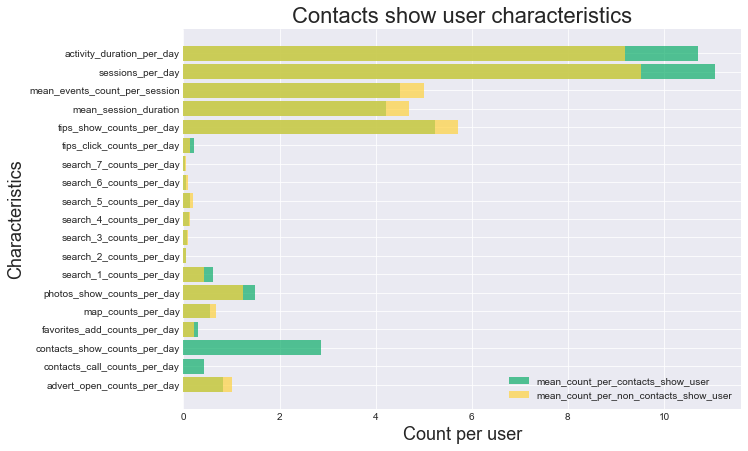

In [108]:
plt.figure(figsize=(10, 7))    
plt.barh(users_mean_indicators['indicator'], users_mean_indicators['mean_count_per_contacts_show_user'], 
         alpha=0.7, color='#0ead69')  
plt.barh(users_mean_indicators['indicator'], users_mean_indicators['mean_count_per_non_contacts_show_user'], 
         alpha=0.7, color='#ffd23f')

plt.legend(['mean_count_per_contacts_show_user', 'mean_count_per_non_contacts_show_user'])
        
plt.title('Contacts show user characteristics', fontsize=22)       
plt.xlabel('Count per user', fontsize=18)     
plt.ylabel('Characteristics', fontsize=18)

plt.show()

Для пользователей, хотя бы раз совершивших действие "посмотреть контакты", по отношению к пользователям, не совершавшим этого дейстия, характерны:
- более длительное взаимодействие с приложением в течение дня;
- большее количество сессий в день;
- при меньшем количестве показов рекомендованных объявлений, большее количество кликов по ним;
- больше поисковых действий search_1;
- меньшее количество действий в течение одной сессии;
- меньшая длительность сессии;
- меньше открытий карточек объявлений.

Рассчитаем в каждой группе долю кликов по рекомендованному объявлению в общем количестве показов таких объявлений:

Выделим группу А - пользователей, которые хоть раз открыли контакты в объявлении. И группу В - все остальные.

In [109]:
group_a_users = sessions.query('event_name=="contacts_show"')['user_id'].unique()
group_a = sessions.query('user_id in @group_a_users')
group_b = sessions.query('user_id not in @group_a_users')

In [110]:
group_a_tips_show = group_a.query('event_name=="tips_show"').groupby('user_id').agg({'event_time': 'count'}).reset_index()
group_a_tips_show.columns = ['user_id', 'tips_show_count']
group_a_tips_show.head()

,user_id,tips_show_count
0,005fbea5-2678-406f-88a6-fbe9787e2268,2
1,007d031d-5018-4e02-b7ee-72a30609173f,5
2,0103a07d-513f-42b9-8d91-d5891d5655fe,1
3,035ae717-a6ae-4569-b952-16be9447832b,23
4,03739d15-7212-415c-9c88-4dfc24b8d3b5,4


In [111]:
group_a_tips_click = group_a.query('event_name=="tips_click"').groupby('user_id').agg({'event_time': 'count'}).reset_index()
group_a_tips_click.columns = ['user_id', 'tips_click_count']
group_a_tips_click.head()

,user_id,tips_click_count
0,06bdb96e-2712-47b3-a0af-d19f297abd6c,13
1,081bb564-703e-4f1c-9016-ac9460dec5bf,4
2,0d03c0d5-8463-40a5-a9bc-c688f7058ddb,2
3,0edcd514-9e76-41dd-9d14-c7e35bfcca78,6
4,136b7b37-2bd4-4718-b14a-e38bc3d6d112,1


Соединим эти данные:

In [112]:
group_a_tips_click_per_show = group_a_tips_show.merge(group_a_tips_click, on='user_id', how='left')
group_a_tips_click_per_show.head()

,user_id,tips_show_count,tips_click_count
0,005fbea5-2678-406f-88a6-fbe9787e2268,2,NaN
1,007d031d-5018-4e02-b7ee-72a30609173f,5,NaN
2,0103a07d-513f-42b9-8d91-d5891d5655fe,1,NaN
3,035ae717-a6ae-4569-b952-16be9447832b,23,NaN
4,03739d15-7212-415c-9c88-4dfc24b8d3b5,4,NaN


Заменим отсутствующие значение нулями:

In [113]:
group_a_tips_click_per_show = group_a_tips_click_per_show.fillna(0)
group_a_tips_click_per_show.head()

,user_id,tips_show_count,tips_click_count
0,005fbea5-2678-406f-88a6-fbe9787e2268,2,0.0
1,007d031d-5018-4e02-b7ee-72a30609173f,5,0.0
2,0103a07d-513f-42b9-8d91-d5891d5655fe,1,0.0
3,035ae717-a6ae-4569-b952-16be9447832b,23,0.0
4,03739d15-7212-415c-9c88-4dfc24b8d3b5,4,0.0


Посчитаем долю кликов на один показ:

In [114]:
group_a_tips_click_per_show['tips_click_share'] = (group_a_tips_click_per_show['tips_click_count'] 
                                                 / group_a_tips_click_per_show['tips_show_count']).round(2) 
group_a_tips_click_per_show.head()

,user_id,tips_show_count,tips_click_count,tips_click_share
0,005fbea5-2678-406f-88a6-fbe9787e2268,2,0.0,0.0
1,007d031d-5018-4e02-b7ee-72a30609173f,5,0.0,0.0
2,0103a07d-513f-42b9-8d91-d5891d5655fe,1,0.0,0.0
3,035ae717-a6ae-4569-b952-16be9447832b,23,0.0,0.0
4,03739d15-7212-415c-9c88-4dfc24b8d3b5,4,0.0,0.0


Аналогично исследуем долю кликов по рекомендованным объявлениям в группе пользователей, ни разу не открывших контакты в объявлении:

In [115]:
group_b_tips_show = group_b.query('event_name=="tips_show"').groupby('user_id').agg({'event_time': 'count'}).reset_index()
group_b_tips_show.columns = ['user_id', 'tips_show_count']
group_b_tips_show.head()

,user_id,tips_show_count
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,29
1,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,4
2,00554293-7e00-4122-b898-4e892c4a7c53,9
3,009c0f37-8556-4c72-a007-100e28a37373,8
4,00aa4003-366b-4788-ad1f-506f2b51b8cb,3


In [116]:
group_b_tips_click = group_b.query('event_name=="tips_click"').groupby('user_id').agg({'event_time': 'count'}).reset_index()
group_b_tips_click.columns = ['user_id', 'tips_click_count']
group_b_tips_click.head()

,user_id,tips_click_count
0,01147bf8-cd48-49c0-a5af-3f6eb45f8262,2
1,01b4ca51-930d-4518-aa09-8a8c35e1d9cc,1
2,02ac1c07-7a45-4d4b-9dbe-bea066039c01,1
3,02e7c193-842b-4995-b67a-8c87ac0f29bb,1
4,034a556c-8837-4c78-8012-795e03764657,1


Соединим эти данные:

In [117]:
group_b_tips_click_per_show = group_b_tips_show.merge(group_b_tips_click, on='user_id', how='left')
group_b_tips_click_per_show.head()

,user_id,tips_show_count,tips_click_count
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,29,NaN
1,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,4,NaN
2,00554293-7e00-4122-b898-4e892c4a7c53,9,NaN
3,009c0f37-8556-4c72-a007-100e28a37373,8,NaN
4,00aa4003-366b-4788-ad1f-506f2b51b8cb,3,NaN


Заменим отсутствующие значение нулями:

In [118]:
group_b_tips_click_per_show = group_b_tips_click_per_show.fillna(0)
group_b_tips_click_per_show.head()

,user_id,tips_show_count,tips_click_count
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,29,0.0
1,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,4,0.0
2,00554293-7e00-4122-b898-4e892c4a7c53,9,0.0
3,009c0f37-8556-4c72-a007-100e28a37373,8,0.0
4,00aa4003-366b-4788-ad1f-506f2b51b8cb,3,0.0


Посчитаем долю кликов на один показ:

In [119]:
group_b_tips_click_per_show['tips_click_share'] = (group_b_tips_click_per_show['tips_click_count'] 
                                                 / group_b_tips_click_per_show['tips_show_count']).round(2) 
group_b_tips_click_per_show.head()

,user_id,tips_show_count,tips_click_count,tips_click_share
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,29,0.0,0.0
1,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,4,0.0,0.0
2,00554293-7e00-4122-b898-4e892c4a7c53,9,0.0,0.0
3,009c0f37-8556-4c72-a007-100e28a37373,8,0.0,0.0
4,00aa4003-366b-4788-ad1f-506f2b51b8cb,3,0.0,0.0


Посмотрим на распределение доли кликов по рекомендованным объявлениям к количеству показов этих объявлений в разных группах пользователей:

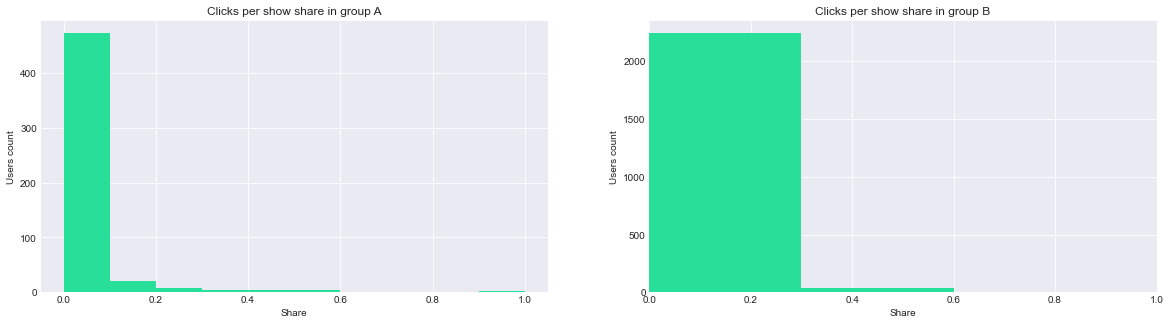

In [120]:
fig = plt.figure()
fig.set_figheight(5)          
fig.set_figwidth(20)

ax_1 = fig.add_subplot(1, 2, 1)
ax_2 = fig.add_subplot(1, 2, 2)

ax_1.hist(group_a_tips_click_per_show['tips_click_share'], color='#28df99')
ax_1.set_title('Clicks per show share in group A')
ax_1.set_xlabel('Share')
ax_1.set_ylabel('Users count')

ax_2.hist(group_b_tips_click_per_show['tips_click_share'], color='#28df99')
ax_2.set_title('Clicks per show share in group B')
ax_2.set_xlabel('Share')
ax_2.set_xlim(0, 1)
ax_2.set_ylabel('Users count')

plt.show()

Пользователи в группе А менее склонны кликать по рекомендованным объявлениям, чем в группе В. При этом группа А состоит из пользователей, открывающих контакты в объявлениях. 

Из этого можно сделать два вывода:
1. пользователи группы А более избирательны и целенаправлены в поисках "ненужных вещей" в приложении;
2. рекомендательная система работает не очень хорошо - она не "предугадывает" потребности более мотивированной к просмотру контактов в объявлениях аудитории.

**Поведение пользователей, совершивших и не совершивших действие contacts_call**

Сделаем срез по событию contacts_call:

In [121]:
contacts_call_users = users.query('contacts_call_counts_per_day > 0')
contacts_call_users.head(2)

,user_id,advert_open_counts_per_day,contacts_call_counts_per_day,contacts_show_counts_per_day,favorites_add_counts_per_day,map_counts_per_day,photos_show_counts_per_day,search_1_counts_per_day,search_2_counts_per_day,search_3_counts_per_day,search_4_counts_per_day,search_5_counts_per_day,search_6_counts_per_day,search_7_counts_per_day,tips_click_counts_per_day,tips_show_counts_per_day,mean_session_duration,mean_events_count_per_session,sessions_per_day,activity_duration_per_day
1,00157779-810c-4498-9e05-a1e9e3cedf93,1.0,2.5,2.75,1.0,0.0,6.6,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.67,5.46,11.83,18.77
4,00551e79-152e-4441-9cf7-565d7eb04090,0.0,1.5,1.50,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.27,2.67,2.67,4.27


Выведем количество пользователей, совершивших событие contacts_call:

In [122]:
contacts_call_users['user_id'].count()

213

In [123]:
contacts_call_users_mean_indicators = contacts_call_users.mean().reset_index()
contacts_call_users_mean_indicators.columns = ['indicator', 'mean_count_per_contacts_call_user']
contacts_call_users_mean_indicators

,indicator,mean_count_per_contacts_call_user
0,advert_open_counts_per_day,0.362676
1,contacts_call_counts_per_day,1.987872
2,contacts_show_counts_per_day,2.873396
3,favorites_add_counts_per_day,0.528169
4,map_counts_per_day,0.000000
5,photos_show_counts_per_day,2.845652
6,search_1_counts_per_day,1.170395
7,search_2_counts_per_day,0.000000
8,search_3_counts_per_day,0.000000
9,search_4_counts_per_day,0.000000


Сделаем срез по отсутствию события contacts_call:

In [124]:
non_contacts_call_users = users.query('contacts_call_counts_per_day == 0')
non_contacts_call_users.head(2)

,user_id,advert_open_counts_per_day,contacts_call_counts_per_day,contacts_show_counts_per_day,favorites_add_counts_per_day,map_counts_per_day,photos_show_counts_per_day,search_1_counts_per_day,search_2_counts_per_day,search_3_counts_per_day,search_4_counts_per_day,search_5_counts_per_day,search_6_counts_per_day,search_7_counts_per_day,tips_click_counts_per_day,tips_show_counts_per_day,mean_session_duration,mean_events_count_per_session,sessions_per_day,activity_duration_per_day
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.25,5.69,5.0,8.75,9.96
2,00463033-5717-4bf1-91b4-09183923b9df,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,8.48,5.0,10.00,16.97


Выведем количество пользователей, не совершивших событие contacts_call:

In [125]:
non_contacts_call_users['user_id'].count()

4080

In [126]:
non_contacts_call_users_mean_indicators = non_contacts_call_users.mean().reset_index()
non_contacts_call_users_mean_indicators.columns = ['indicator', 'mean_count_per_non_contacts_call_user']
non_contacts_call_users_mean_indicators

,indicator,mean_count_per_non_contacts_call_user
0,advert_open_counts_per_day,1.003365
1,contacts_call_counts_per_day,0.000000
2,contacts_show_counts_per_day,0.539878
3,favorites_add_counts_per_day,0.230007
4,map_counts_per_day,0.684279
5,photos_show_counts_per_day,1.209224
6,search_1_counts_per_day,0.437639
7,search_2_counts_per_day,0.065291
8,search_3_counts_per_day,0.099400
9,search_4_counts_per_day,0.128456


Соединим данные по пользователям, хоть раз открывшим контакты продавца, и по пользователям, не сделавшим этого:

In [127]:
users_mean_indicators = contacts_call_users_mean_indicators.merge(non_contacts_call_users_mean_indicators,
                                                                 on='indicator', how='left')
users_mean_indicators

,indicator,mean_count_per_contacts_call_user,mean_count_per_non_contacts_call_user
0,advert_open_counts_per_day,0.362676,1.003365
1,contacts_call_counts_per_day,1.987872,0.000000
2,contacts_show_counts_per_day,2.873396,0.539878
3,favorites_add_counts_per_day,0.528169,0.230007
4,map_counts_per_day,0.000000,0.684279
5,photos_show_counts_per_day,2.845652,1.209224
6,search_1_counts_per_day,1.170395,0.437639
7,search_2_counts_per_day,0.000000,0.065291
8,search_3_counts_per_day,0.000000,0.099400
9,search_4_counts_per_day,0.000000,0.128456


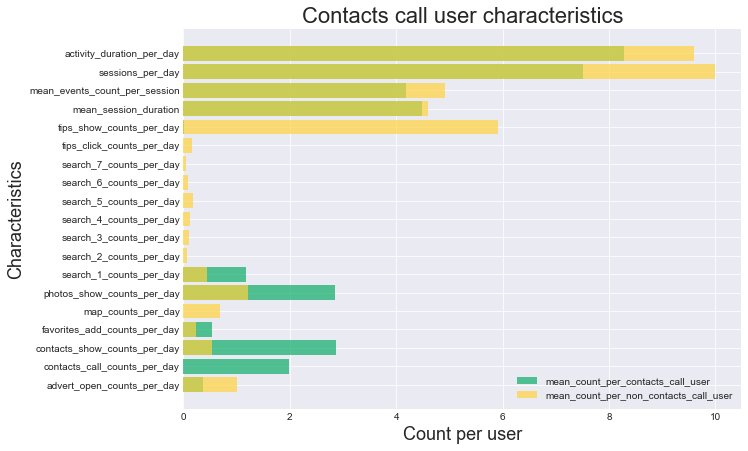

In [128]:
plt.figure(figsize=(10, 7))    
plt.barh(users_mean_indicators['indicator'], users_mean_indicators['mean_count_per_contacts_call_user'], 
         alpha=0.7, color='#0ead69')  
plt.barh(users_mean_indicators['indicator'], users_mean_indicators['mean_count_per_non_contacts_call_user'], 
         alpha=0.7, color='#ffd23f')

plt.legend(['mean_count_per_contacts_call_user', 'mean_count_per_non_contacts_call_user'])
        
plt.title('Contacts call user characteristics', fontsize=22)       
plt.xlabel('Count per user', fontsize=18)     
plt.ylabel('Characteristics', fontsize=18)

plt.show()

Для пользователей, хотя бы раз позвонивших по номеру телефона в карточке объявления, характерны:
- практически отсутствие просмотров рекомендованных объявлений;
- отсутствие просмотра карты объявлений;
- более активный просмотр фотографий в объявлениях;
- более активный поиск search_1 и отсутствие других поисковых событий;
- малое количество открытий объявлений.

**Возможная сегментация пользователей**

Несмотря на то, что монетизация приложения заключается в сборе средств с продавцов "ненужных вещей" за продвижение их объявлений в списке рекомендованных, смыслом данного приложения является его способность продавать. Конечным этапом воронки продаж в данном приложении является звонок по телефону, указанному в объявлении. Поэтому привлечение пользователей, осуществляющих звонки продавцам, является ключевой задачей данного приложения. 

<em>Aha-moment в изучении пользователей, осуществляющих звонки продавцам, состоит в том, что такой пользователь, как правило, совершает более двух событий "photos_show" в день при отсутствии событий "map" и "tips_show"</em>

На основании этого возможна сегментация пользователей по наличию более 2 просмотров фотографий в день при отсутствии просмотров рекомендованных объявлений и карты объявлений.

**Выводы по шагу 3:**
- Наибольшей популярностью пользуются такие события, как просмотр рекомендованных объявлений, просмотр фотографий и открытие объявления.
- Типичная длительность сессии составляет от 1 до 4 минут.
- Пользователям свойственно осуществлять 4-5 действий за одну сессию.
- В основном, взаимодействие с приложением происходит в течение 10 минут в день. 
- Для более активных пользователей, просматривающих контакты и осуществляющих звонки продавцам, характерны более частые просмотры фотографий, большая склонность помещать объявления в избранное, а также поисковые действия search_1.

<h2>Шаг 4. Сегментация пользователей<a id="step4"></a></h2>

На этапе исследовательского анализа мы сформировали таблицу с характеристиками пользователей. Характеристики приведены к виду средних значений для пользователя в день. Поэтому в выборку для кластеризации возьмём всех пользователей, в том числе тех, кто скачал приложение в последний день исследования.

In [129]:
users.head(2)

,user_id,advert_open_counts_per_day,contacts_call_counts_per_day,contacts_show_counts_per_day,favorites_add_counts_per_day,map_counts_per_day,photos_show_counts_per_day,search_1_counts_per_day,search_2_counts_per_day,search_3_counts_per_day,search_4_counts_per_day,search_5_counts_per_day,search_6_counts_per_day,search_7_counts_per_day,tips_click_counts_per_day,tips_show_counts_per_day,mean_session_duration,mean_events_count_per_session,sessions_per_day,activity_duration_per_day
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.0,0.0,0.00,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.25,5.69,5.00,8.75,9.96
1,00157779-810c-4498-9e05-a1e9e3cedf93,1.0,2.5,2.75,1.0,0.0,6.6,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,8.67,5.46,11.83,18.77


Для целей кластеризации возьмём данные без user_id:

In [130]:
X = users.drop(columns=['user_id'])

Нормализуем и стандартизируем данные:

In [131]:
scaler = StandardScaler()   # создадим объект класса StandardScaler
X_sc = scaler.fit_transform(X)

Построим матрицу расстояний на стандартизованной матрице признаков:

In [132]:
linked = linkage(X_sc, method = 'ward')  #таблица «связок» между объектами-пользователями
linked[:5]

array([[3.601e+03, 3.743e+03, 0.000e+00, 2.000e+00],
       [1.800e+01, 2.849e+03, 0.000e+00, 2.000e+00],
       [2.000e+01, 2.361e+03, 0.000e+00, 2.000e+00],
       [2.685e+03, 2.743e+03, 0.000e+00, 2.000e+00],
       [2.704e+03, 3.104e+03, 0.000e+00, 2.000e+00]])

Чтобы визуализировать матрицу расстояний, построим дендрограмму:

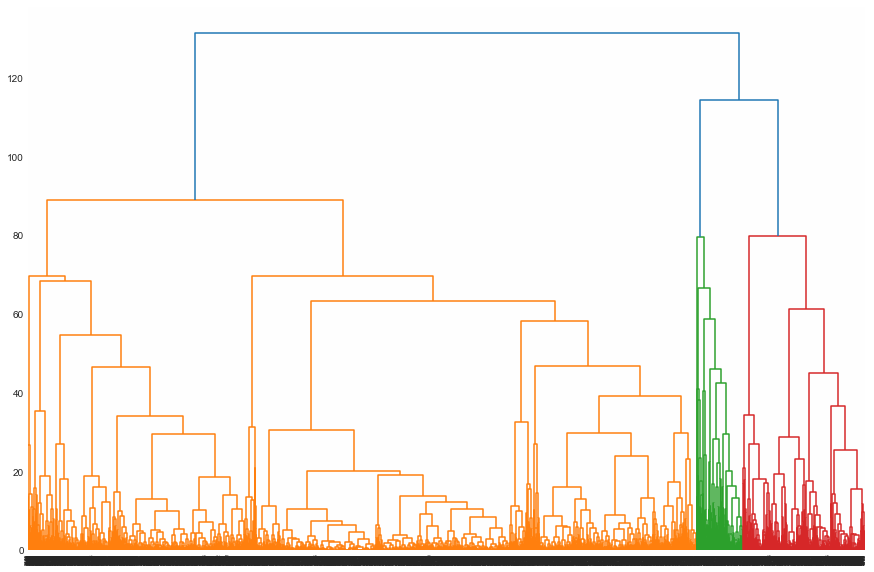

In [133]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

Дендрограмма предлагает разделить пользователей на 3 кластера.

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Следуя логике и результату построенной выше дендрограммы, за число кластеров примем n=3:

In [134]:
km = KMeans(n_clusters = 3, random_state=0) #Задаём модель с числом кластеров

Прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2, в соответствии с заданным числом кластеров)

In [135]:
labels = km.fit_predict(X_sc)

Cохраняем метки кластера в поле исходного датасета users:

In [136]:
users['cluster_km'] = labels
users.head()

,user_id,advert_open_counts_per_day,contacts_call_counts_per_day,contacts_show_counts_per_day,favorites_add_counts_per_day,map_counts_per_day,photos_show_counts_per_day,search_1_counts_per_day,search_2_counts_per_day,search_3_counts_per_day,...,search_5_counts_per_day,search_6_counts_per_day,search_7_counts_per_day,tips_click_counts_per_day,tips_show_counts_per_day,mean_session_duration,mean_events_count_per_session,sessions_per_day,activity_duration_per_day,cluster_km
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.0,0.0,0.00,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.25,5.69,5.00,8.75,9.96,0
1,00157779-810c-4498-9e05-a1e9e3cedf93,1.0,2.5,2.75,1.0,0.0,6.6,4.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,8.67,5.46,11.83,18.77,0
2,00463033-5717-4bf1-91b4-09183923b9df,0.0,0.0,0.00,0.0,0.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,8.48,5.00,10.00,16.97,0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,5.0,0.0,0.00,0.0,1.5,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,2.00,1.93,2.46,5.33,4.17,1
4,00551e79-152e-4441-9cf7-565d7eb04090,0.0,1.5,1.50,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,4.27,2.67,2.67,4.27,0


Выводим статистику средних значений признаков по каждому кластеру:

In [137]:
users.groupby('cluster_km').mean()

,advert_open_counts_per_day,contacts_call_counts_per_day,contacts_show_counts_per_day,favorites_add_counts_per_day,map_counts_per_day,photos_show_counts_per_day,search_1_counts_per_day,search_2_counts_per_day,search_3_counts_per_day,search_4_counts_per_day,search_5_counts_per_day,search_6_counts_per_day,search_7_counts_per_day,tips_click_counts_per_day,tips_show_counts_per_day,mean_session_duration,mean_events_count_per_session,sessions_per_day,activity_duration_per_day
cluster_km,,,,,,,,,,,,,,,,,,,
0,0.536354,0.107348,0.536720,0.183132,0.487154,1.315721,0.559933,0.000000,0.054850,0.009831,0.011429,0.000614,0.003175,0.117127,3.689290,3.993355,3.988719,7.018648,7.157048
1,0.792079,0.000000,0.426647,0.194722,0.744370,0.013333,0.009167,0.412315,0.107944,0.735167,1.138110,0.586825,0.263151,0.124861,5.829525,3.331733,4.566683,9.788983,7.844217
2,4.451832,0.168950,1.853247,0.771689,1.734138,2.851788,0.472097,0.043379,0.370434,0.116438,0.114155,0.025114,0.020548,0.437215,19.598302,10.701804,12.015342,31.143927,29.561393


Один из кластеров состоит из наиболее активных пользователей со следующими характеристиками:
- в несколько раз дольше остальных взаимодействуют с приложением в течение дня;
- в разы больше сессий в течение дня и  действий внутри одной сессии;
- более длительные сессии;
- чаще просматривают и кликают по рекомендованным объявлениям;
- чаще просматривают фото и карты объявлений;
- склонны к помещению объявлений в избранное;
- чаще открывают контакты и, соответственно, звонят по телефонам, размещённым в объявлениях;
- в среднем, в 5 раз чаще открывают карточки объявлений.

Два остальных кластера разделены по признаку наличия, либо отсутствия звонков по объявлениям. 

Пользователи, которые иногда звонят, гораздо чаще просматривают фото и осуществляют поиск search_1

Отличительной особенностью пользователей, никогда не звонящих по телефонам в объявлениях, является большее использование поисковых алгоритмов search_2 и search_4 - search_7, чем пользователи остальных кластеров.

Проитерируемся по признакам, построив диаграммы распределения:

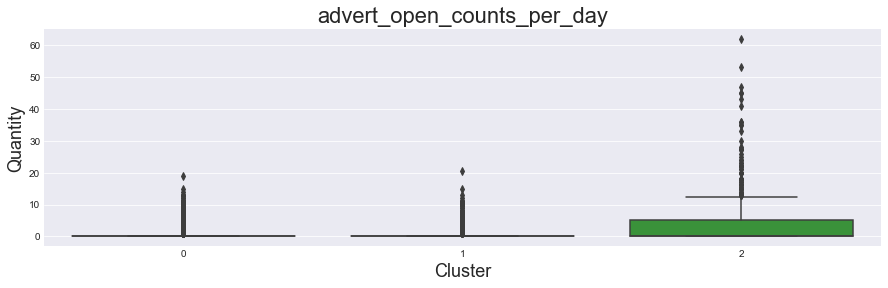

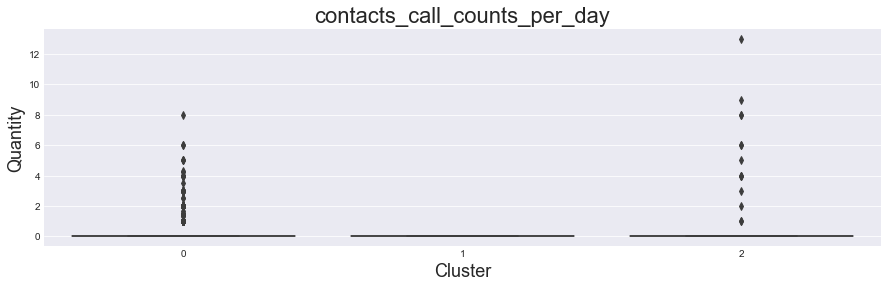

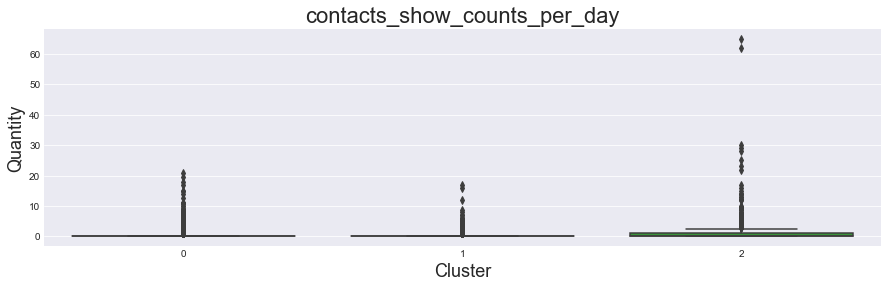

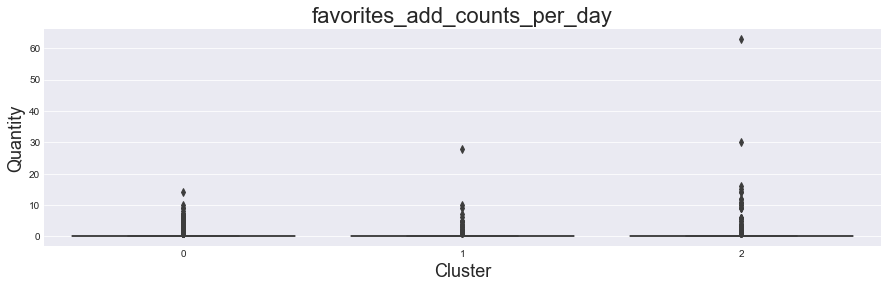

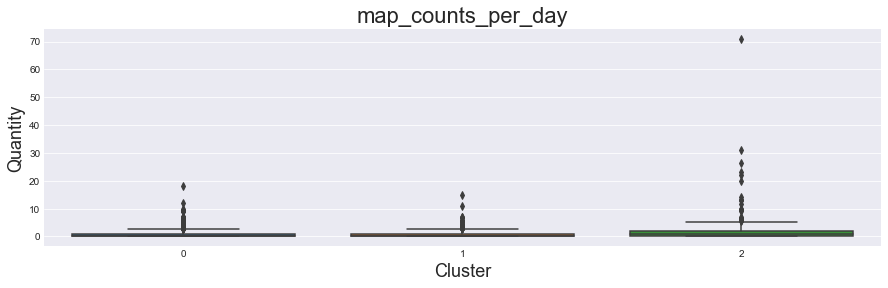

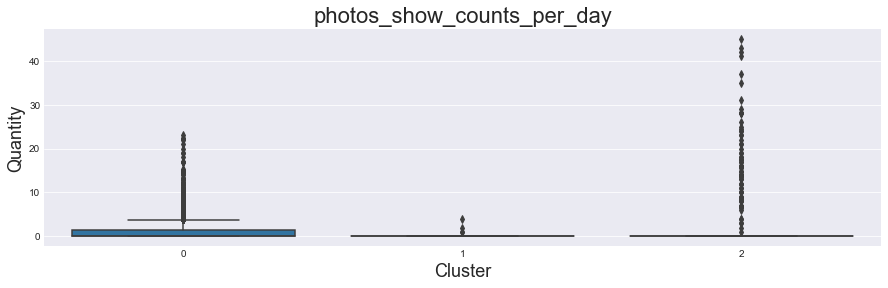

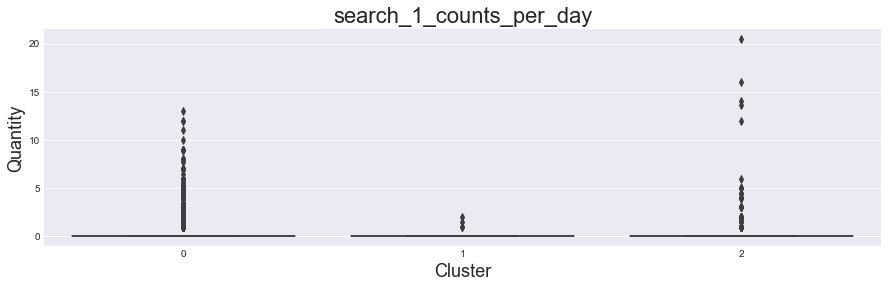

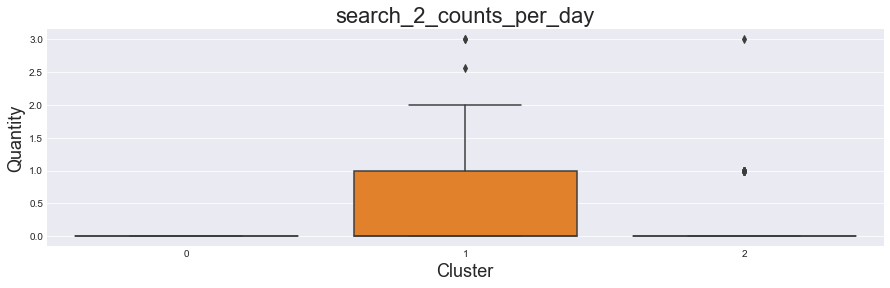

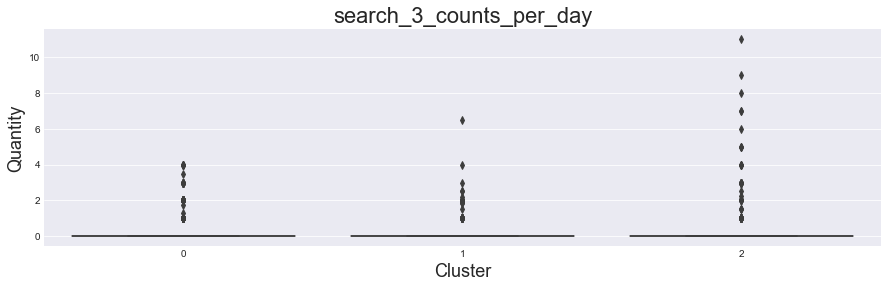

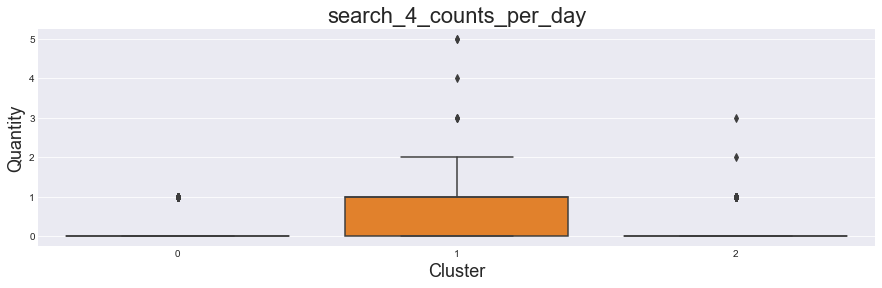

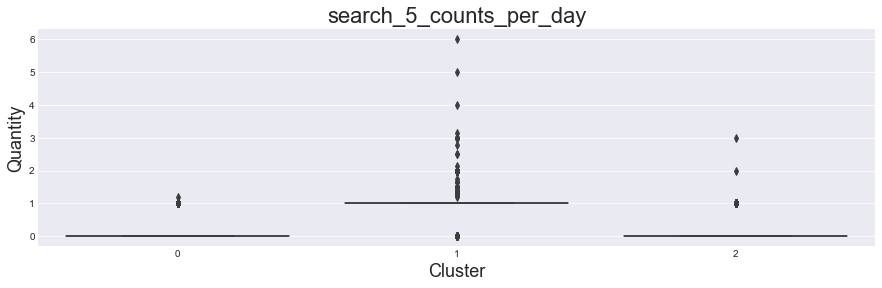

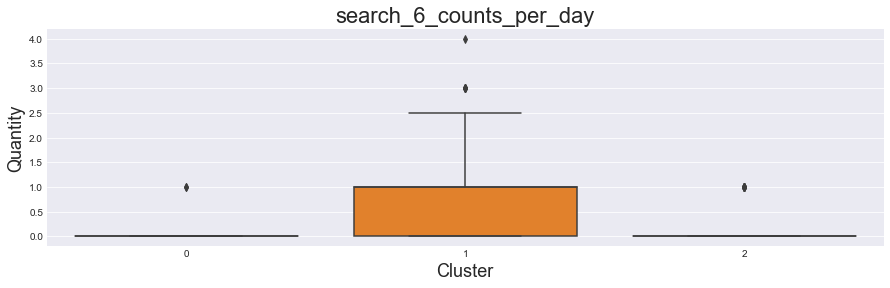

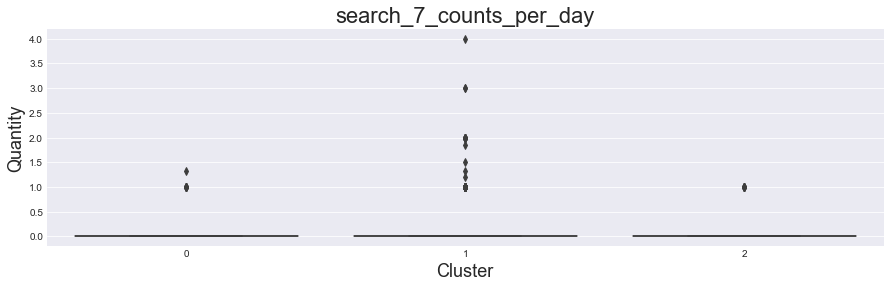

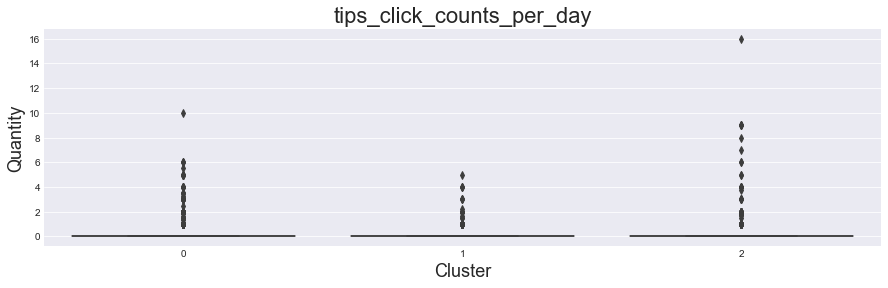

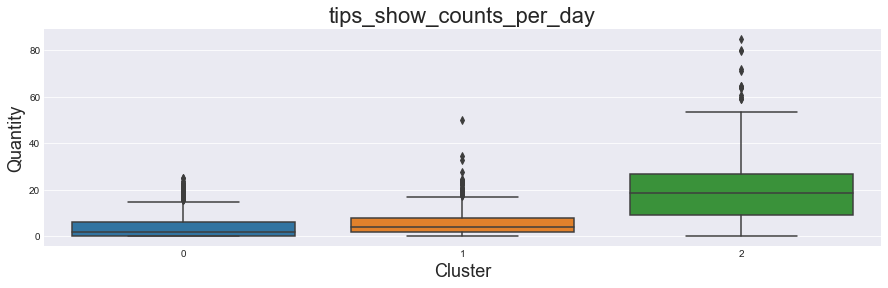

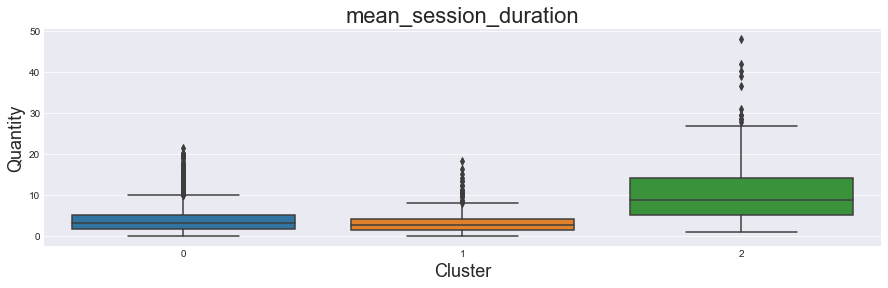

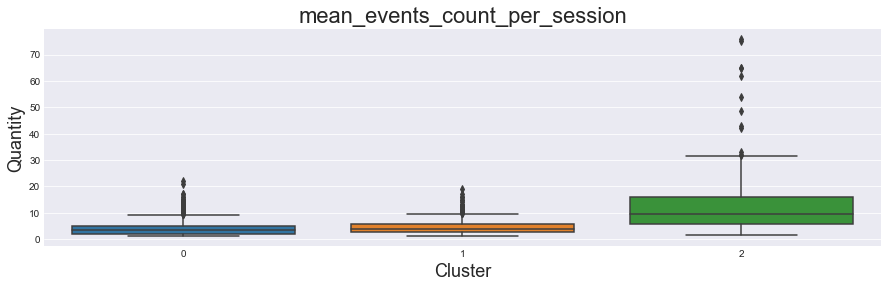

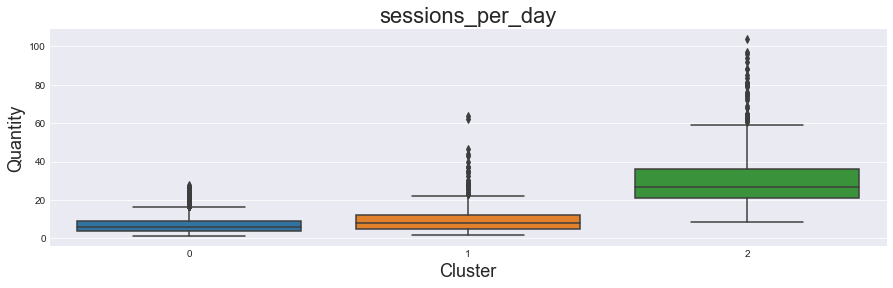

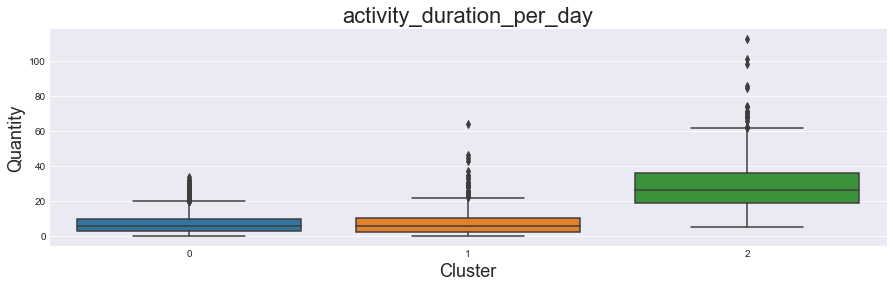

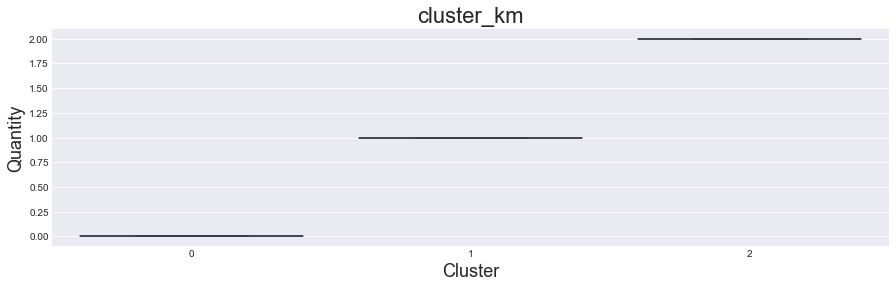

In [138]:
for column in users.columns:
    
    if column != "user_id":
        plt.figure(figsize=(15, 4))
        sns.boxplot(data=users, x='cluster_km', y=column)
        plt.title(column, fontsize=22)
        plt.xlabel('Cluster', fontsize=18)
        plt.ylabel('Quantity', fontsize=18)
        plt.show()

Диаграммы наглядно иллюстрируют характеристики кластеров, описанные выше. Хорошо просматривается отличие более активного кластера, а также активность по поисковым событиям кластера пользователей, не осуществляющих телефонные звонки по объявлениям.

**Валидация сегментов**

Для каждого пользователя определим первый и последний день взаимодействия с приложением:

In [139]:
users_activity_periods = sessions.groupby(['user_id']).agg({'event_date': ['min', 'max']}).reset_index()
users_activity_periods.columns = ['user_id', 'first_activity_date', 'last_activity_date']
users_activity_periods.head()

,user_id,first_activity_date,last_activity_date
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2019-10-22
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19,2019-11-03
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01,2019-11-01
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18,2019-10-31
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25,2019-10-29


Рассчитаем продолжительность активности пользователя в днях:

In [140]:
users_activity_periods['activity_days'] = (users_activity_periods['last_activity_date'] 
                                          - users_activity_periods['first_activity_date'] 
                                          + pd.Timedelta(days=1)) / np.timedelta64(1,'D')
users_activity_periods['activity_days'] = users_activity_periods['activity_days'].astype('int')
users_activity_periods.head()

,user_id,first_activity_date,last_activity_date,activity_days
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2019-10-22,16
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19,2019-11-03,16
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01,2019-11-01,1
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18,2019-10-31,14
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25,2019-10-29,5


Из датафрейма users сохраним user_id и cluster_km в отдельном датафрейме:

In [141]:
user_clasters = users[['user_id', 'cluster_km']]

Добавим метки кластеров:

In [142]:
users_activity_periods = users_activity_periods.merge(user_clasters, on='user_id', how='left')
users_activity_periods.head()

,user_id,first_activity_date,last_activity_date,activity_days,cluster_km
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2019-10-22,16,0
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19,2019-11-03,16,0
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01,2019-11-01,1,0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18,2019-10-31,14,1
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25,2019-10-29,5,0


Полученные данные позволяют определить коэффициент удержания пользователей.

<em>**Retention Rate**</em>

Рассчитаем коэффициент удержания 14 дня пользования приложением. В каждом сегменте пользователей определим количество тех, чей показатель activity_days не меньше 14 дней:

In [143]:
users_activity_periods_grouped_by_clasters = (users_activity_periods.query('activity_days>=14')
                                              .groupby('cluster_km')
                                              .agg({'user_id': 'count'})
                                              .reset_index()
                                             )
users_activity_periods_grouped_by_clasters.columns = ['cluster_km', 'users_count']
users_activity_periods_grouped_by_clasters

,cluster_km,users_count
0,0,239
1,1,68
2,2,16


Определим общий размер сегментов:

In [144]:
claster_volumes = (users_activity_periods.groupby('cluster_km')
                                            .agg({'user_id': 'count'})
                                            .reset_index()
                                            )
claster_volumes.columns = ['cluster_km', 'claster_users_count']
claster_volumes

,cluster_km,claster_users_count
0,0,3255
1,1,600
2,2,438


Объединим данные о размерах кластеров:

In [145]:
users_activity_periods_grouped_by_clasters = users_activity_periods_grouped_by_clasters.merge(claster_volumes, on='cluster_km', how='left')
users_activity_periods_grouped_by_clasters = users_activity_periods_grouped_by_clasters.rename(columns={'users_count':'retention_users_count'})
users_activity_periods_grouped_by_clasters

,cluster_km,retention_users_count,claster_users_count
0,0,239,3255
1,1,68,600
2,2,16,438


Определим долю в каждом кластере:

In [146]:
users_activity_periods_grouped_by_clasters['users_share'] = (users_activity_periods_grouped_by_clasters['retention_users_count'] 
                                                            / users_activity_periods_grouped_by_clasters['claster_users_count'])
users_activity_periods_grouped_by_clasters

,cluster_km,retention_users_count,claster_users_count,users_share
0,0,239,3255,0.073425
1,1,68,600,0.113333
2,2,16,438,0.036530


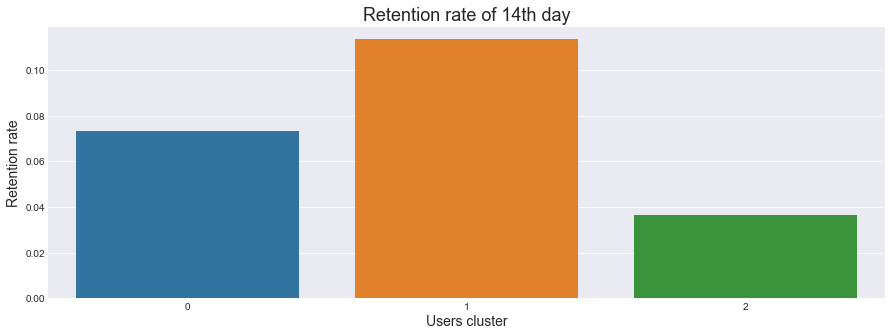

In [147]:
plt.figure(figsize=(15, 5))
sns.barplot(data=users_activity_periods_grouped_by_clasters, x='cluster_km', y='users_share')  
plt.title('Retention rate of 14th day', fontsize=18)
plt.xlabel('Users cluster', fontsize=14)
plt.ylabel('Retention rate', fontsize=14)
plt.show()

Самый низкий Retention Rate 14 дня 3,5% в сегменте самых активных и покупающих пользователей. Самый высокий коэфициент удержания 11,4% в сегменте пользователей, не звонящих по объявлениям. Самый крупный сегмент, состоящий из всех остальных пользователей, которые немного времени уделяют приложению в течение дня, но иногда совершают звонки по объявлениям, имеет Retention Rate на уровне 7,3%.

Из этого следует, что у самых эффективных по количеству звонков пользователей модель поведения состоит из ситуативных потребностей в "ненужных вещах", когда они начинают интенсивно использовать приложение, доводя взаимодействие до возможной покупки (звонка продавцу) Они не склонны надолго оставаться. Возможно, пока снова не появится потребность в ненужной вещи. Необходимо провести исследование на большем периоде времени, чтобы определить цикл покупки и вероятность возвращения активного покупателя через более продолжительный период времени.

Довольно высокий показатель удержания в сегменте пользователей, которые ничего не покупают, требуют более тщательного изучения для определения причин. Возможно, это не покупатели, а продавцы, которые просто мониторят рынок. Косвенным подтверждением этому является склонность этих пользователей использовать непопулярные для остальных сегментов поисковые события search.

<em>**Время, проведённое в приложении**</em>

In [148]:
users_activity_periods.head()

,user_id,first_activity_date,last_activity_date,activity_days,cluster_km
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2019-10-22,16,0
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19,2019-11-03,16,0
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01,2019-11-01,1,0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18,2019-10-31,14,1
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25,2019-10-29,5,0


Рассчитаем среднее количество дней пользования приложением для каждого сегмента пользователей:

In [149]:
mean_clasters_activity = users_activity_periods.groupby('cluster_km').agg({'activity_days': 'mean'}).reset_index()
mean_clasters_activity.columns = ['cluster_km', 'mean_activity_days']
mean_clasters_activity

,cluster_km,mean_activity_days
0,0,3.574194
1,1,4.511667
2,2,2.673516


Сегменты различаются по среднему времени проведённому в приложении. 

Присоединим данные к таблице users_activity_periods_grouped_by_clasters:

In [150]:
clasters = users_activity_periods_grouped_by_clasters.merge(mean_clasters_activity, on='cluster_km', how='left')
clasters

,cluster_km,retention_users_count,claster_users_count,users_share,mean_activity_days
0,0,239,3255,0.073425,3.574194
1,1,68,600,0.113333,4.511667
2,2,16,438,0.036530,2.673516


<em>**Частота действий за сессию**</em>

Для определения различий сегментов по средней частоте действий за сессию воспользуемся уже имеющимся датафреймом:

In [151]:
events_and_sessions.head()

,user_id,sessions_ids,events_count,session_duration
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1.0,8,9.93
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2.0,2,2.57
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3.0,2,2.82
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4.0,11,10.39
4,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,5.0,3,3.46


Присоединим маркеры принадлежности к кластеру пользователей к данным о сессиях:

In [152]:
events_and_sessions = events_and_sessions.merge(user_clasters, on='user_id', how='left')
events_and_sessions.head()

,user_id,sessions_ids,events_count,session_duration,cluster_km
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1.0,8,9.93,0
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2.0,2,2.57,0
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3.0,2,2.82,0
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4.0,11,10.39,0
4,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,5.0,3,3.46,0


Рассчитаем среднее количество действий за сессию для каждого кластера пользователей:

In [153]:
mean_events_count_per_session_by_clasters = events_and_sessions.groupby('cluster_km').agg({'events_count': 'mean'}).reset_index()
mean_events_count_per_session_by_clasters.columns = ['cluster_km', 'mean_events_count_per_session']
mean_events_count_per_session_by_clasters

,cluster_km,mean_events_count_per_session
0,0,3.246737
1,1,3.871266
2,2,6.275803


Средние значения в двух кластерах выглядят одинаково. Проверим их различие или сходство статистическим методом. Применим критерий T-стьюдента.

Сформулируем нулевую и альтернативную гипотезы.

Нулевая гипотеза: средние значения количества пользовательских действий за сессию в двух кластерах одинаковы.
Альтернативная гипотеза: средние значения количества пользовательских действий за сессию в двух кластерах различаются.

Критический уровень статистической значимости установим на уровне 5%:

In [154]:
alpha = .05

Проверим гипотезу о равенстве средних двух независимых совокупностей. Определим p-уровень значимости:

In [155]:
results = st.ttest_ind(events_and_sessions.query('cluster_km==0')['events_count'], 
                       events_and_sessions.query('cluster_km==2')['events_count'])
results.pvalue

3.6320694306936484e-224

In [156]:
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
    
else:
    print('Отвергнуть нулевую гипотезу не получилось')

Отвергаем нулевую гипотезу


Получили подтверждение различия, на первый взгляд похожих, кластеров пользователей.

Присоединим данные о средних значениях количества действий за сессию к таблице clasters:

In [157]:
clasters = clasters.merge(mean_events_count_per_session_by_clasters, on='cluster_km', how='left')
clasters

,cluster_km,retention_users_count,claster_users_count,users_share,mean_activity_days,mean_events_count_per_session
0,0,239,3255,0.073425,3.574194,3.246737
1,1,68,600,0.113333,4.511667,3.871266
2,2,16,438,0.036530,2.673516,6.275803


<em>**Конверсия в целевое действие — просмотр контактов**</em>

Воспользуемся данными датафрейма sessions:

In [158]:
sessions.head()

,event_time,event_name,user_id,next_event_time,event_date,gap_time_minutes,sessions_ids,session_duration
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:40:31.052909,2019-10-07,0.751059,1.0,0.75
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:41:05.722489,2019-10-07,0.577826,1.0,0.58
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:43:20.735461,2019-10-07,2.250216,1.0,2.25
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:45:30.917502,2019-10-07,2.169701,1.0,2.17
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:45:43.212340,2019-10-07,0.204914,1.0,0.20


Присоединим к нему маркеры принадлежности к кластеру пользователей:

In [159]:
sessions = sessions.merge(user_clasters, on='user_id', how='left')
sessions.head()

,event_time,event_name,user_id,next_event_time,event_date,gap_time_minutes,sessions_ids,session_duration,cluster_km
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:40:31.052909,2019-10-07,0.751059,1.0,0.75,0
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:41:05.722489,2019-10-07,0.577826,1.0,0.58,0
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:43:20.735461,2019-10-07,2.250216,1.0,2.25,0
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:45:30.917502,2019-10-07,2.169701,1.0,2.17,0
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:45:43.212340,2019-10-07,0.204914,1.0,0.20,0


Определим количество пользователей в каждом сегменте (кластере), которые хоть раз осуществили действие "просмотр контактов":

In [160]:
contacts_show_users_by_clasters = (sessions
                                   .query('event_name=="contacts_show"')
                                   .groupby('cluster_km')
                                   .agg({'user_id':'nunique'})
                                   .reset_index()
                                  )
contacts_show_users_by_clasters.columns = ['cluster_km','contacts_show_users_count']
contacts_show_users_by_clasters

,cluster_km,contacts_show_users_count
0,0,763
1,1,97
2,2,121


Присоединим данные к таблице clasters:

In [161]:
clasters = clasters.merge(contacts_show_users_by_clasters, on='cluster_km', how='left')
clasters

,cluster_km,retention_users_count,claster_users_count,users_share,mean_activity_days,mean_events_count_per_session,contacts_show_users_count
0,0,239,3255,0.073425,3.574194,3.246737,763
1,1,68,600,0.113333,4.511667,3.871266,97
2,2,16,438,0.036530,2.673516,6.275803,121


Рассчитаем долю пользователей, которые хоть раз осуществили действие "просмотр контактов":

In [162]:
clasters['contacts_show_users_share'] = clasters['contacts_show_users_count'] / clasters['claster_users_count']
clasters

,cluster_km,retention_users_count,claster_users_count,users_share,mean_activity_days,mean_events_count_per_session,contacts_show_users_count,contacts_show_users_share
0,0,239,3255,0.073425,3.574194,3.246737,763,0.234409
1,1,68,600,0.113333,4.511667,3.871266,97,0.161667
2,2,16,438,0.036530,2.673516,6.275803,121,0.276256


Самая низкая конверсия в просмотр контактов 16% в сегменте пользователей, не совершающих звонки. Самая большая 26,8% у самых активных пользователей. Разделение на сегменты произведено корректно. 

**Выводы по шагу 4:**
- Пользователи делятся на три сегмента:
1. осуществляющие звонки по объявлениям активные пользователи, взаимодействующие с приложением около 30 минут в день;
2. осуществляющие звонки по объявлениям пользователи, взаимодействующие с приложением около 7 минут в день;
3. не осуществляющие звонки по объявлениям пользователи, взаимодействующие с приложением около 7 минут в день.
- Просмотр фотографий более двух раз в день, а также добавление объявлений в избранное повышают вероятность осуществления звонка по объявлению.
- Корректность разделения пользователей на сегменты проверена по метрикам:
    - retention rate: 
    - время, проведённое в приложении;
    - частота действий за сессию,
    - конверсия в целевое действие — просмотр контактов.

<h2>Шаг 5. Проверка статистических гипотез<a id="step5"></a></h2>

Определим конверсию в просмотры контактов для пользователей, установивших приложение по ссылкам из yandex и из google, по отдельности:

In [163]:
contacts_show_yandex_users = events_data.query('(source=="yandex") &  (event_name=="contacts_show")')['user_id'].nunique()
contacts_show_yandex_users

478

In [164]:
total_yandex_users = events_data.query('source=="yandex"')['user_id'].nunique()
total_yandex_users

1934

In [165]:
contacts_show_google_users = events_data.query('(source=="google") &  (event_name=="contacts_show")')['user_id'].nunique()
contacts_show_google_users

275

In [166]:
total_google_users = events_data.query('source=="google"')['user_id'].nunique()
total_google_users

1129

**Гипотеза №1**

Нулевая гипотеза: доля пользователей, установивших приложение по ссылке из yandex и хотя бы раз осуществивших действие "просмотр контактов", не отличается от аналогичной доли пользователей, установивших приложение по ссылке из google.

Альтернативная гипотеза: доля пользователей, установивших приложение по ссылке из yandex и хотя бы раз осуществивших действие "просмотр контактов", отличается от аналогичной доли пользователей, установивших приложение по ссылке из google.

Напишем функцию, проверяющую нулевую гипотезу о неотличимости долей двух выборок:

In [167]:
def check_hypothesis(alpha, event, success_1, total_1, success_2, total_2):
                     
    '''
    Функция сравнивает статистическим методом
    долю числа успешных исходов success_1 в одной выборке (размером total_1 элементов)
    с долей числа успешных исходов success_2 в другой выборке (размером total_2 элементов)
    с заданным критическим уровнем статистической значимости alpha
    '''

    alpha = alpha
        
    # доля пользователей, совершивших событие, в первой группе:
    p1 = success_1 / total_1

    # доля пользователей, совершивших событие, во второй группе:
    p2 = success_2 / total_2

    # доля пользователей, совершивших событие, в комбинированном датасете:
    p_combined = (success_1 + success_2) / (total_1 + total_2)

    # разница долей в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total_1 + 1/total_2))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('Для события {} p-значение: {:.4f}'.format(event, p_value))

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        
    print()

Установим критический уровень статистической значимости 5%:

In [168]:
alpha = 0.05

В каждой выборке успешными исходами будем считать количество пользователей, хоть раз осуществивших просмотр контактов. Проверим равенство долей:

In [169]:
check_hypothesis(alpha, 'contacts_show', 
        contacts_show_yandex_users, total_yandex_users, 
        contacts_show_google_users, total_google_users)

Для события contacts_show p-значение: 0.8244
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Таким образом, нулевая гипотеза верна: доля пользователей, установивших приложение по ссылке из yandex и хотя бы раз осуществивших действие "просмотр контактов", статистически равна аналогичной доле пользователей, установивших приложение по ссылке из google.

Прежде чем перейти к формулировке и проверке второй гипотезы, определим количество пользователей, которые в среднем взаимодействуют с приложением 10 и более минут в день. Для рассчёта воспользуемся данными колонки 'activity_duration_per_day' датафрейма users, в которой приведены средние значения продолжительности взаимодействия с приложением в день для каждого пользователя.

Определим общее количество пользователей, в среднем проводящих с приложением 10 и более минут в день:

In [170]:
total_up_10_users = users.query('activity_duration_per_day>=10')['user_id'].nunique()
total_up_10_users

1382

Среди них определим количество тех, кто хотя бы раз звонил по объявлению:

In [171]:
success_up_10_users = users.query('(activity_duration_per_day>=10) & (contacts_call_counts_per_day>0)')['user_id'].nunique()
success_up_10_users

59

Определим общее количество пользователей, в среднем проводящих с приложением менее 10 минут в день:

In [172]:
total_less_10_users = users.query('activity_duration_per_day<10')['user_id'].nunique()
total_less_10_users

2911

Среди них определим количество тех, кто хотя бы раз звонил по объявлению:

In [173]:
success_less_10_users = users.query('(activity_duration_per_day<10) & (contacts_call_counts_per_day>0)')['user_id'].nunique()
success_less_10_users

154

**Гипотеза №2**

Нулевая гипотеза: среди пользователей, взаимодействующих с приложением в среднем более 10 минут в день, доля тех, кто хотя бы раз звонил по телефону, указанному в объявлении, не отличается от аналогичной доли пользователей среди тех, кто в среднем взаимодействует с приложением менее 10 минут в день.

Альтернативная гипотеза: среди пользователей, взаимодействующих с приложением в среднем более 10 минут в день, доля тех, кто хотя бы раз звонил по телефону, указанному в объявлении, отличается от аналогичной доли пользователей среди тех, кто в среднем взаимодействует с приложением менее 10 минут в день.

Для проверки гипотезы воспользуемся функцией check_hypothesis() при условии применения критического уровня статистической значимости 5%:

In [174]:
check_hypothesis(alpha, 'activity_duration_per_day', 
        success_up_10_users, total_up_10_users, 
        success_less_10_users, total_less_10_users)

Для события activity_duration_per_day p-значение: 0.1500
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Таким образом, статистически не подтверждается зависимость доли пользователей, хотя бы раз звонивших по объявлению, от того, больше 10 минут в день они взаимодействуют с приложением или меньше.

**Выводы по шагу 5:**
- доля пользователей, установивших приложение по ссылке из yandex и хотя бы раз осуществивших действие "просмотр контактов", не отличается от аналогичной доли пользователей, установивших приложение по ссылке из google;
- среди пользователей, взаимодействующих с приложением в среднем более 10 минут в день, доля тех, кто хотя бы раз звонил по телефону, указанному в объявлении, не отличается от аналогичной доли пользователей среди тех, кто в среднем взаимодействует с приложением менее 10 минут в день.

<h2>Общие выводы по проекту<a id="step6"></a></h2>

1. Представленные исходные данные позволяют сегментировать пользователей на три группы, в зависимости от общей активности и наличия события "звонок по объявлению".
2. Целевой сегмент состоит из наиболее активных пользователей, которые в среднем взаимодействуют с приложением около 30 минут в день, но делают это непродолжительное время: на 14 день от установки приложения их количество падает до 3,5%
3. Наибольший показатель оттока самых активных пользователей обусловлен спецификой приложения, чья функция состоит в сведении покупателей "ненужных вещей" с их продавцами. Достигнув цели - покупки - пользователь уходит, т.к. "ненужные вещи" не являются товаром повседневного спроса.
4. Отличительными особенностями пользователя, осуществляющего телефонные звонки продавцам, являются следующие:
    - около 4 раз в день открывает объявления;
    - более 2 раз в день просматривает фотографии в объявлениях;
    - не склонен просматривать карту объявлений;
    - поиск осуществляет преимущественно действием search_1;
    - активнее остальных просматривает рекомендованные объявления и помещает объявления в избранное.
5. Отличительными характеристиками пользователей, никогда не звонящих по объявлениям, являются следующие:
    - не просматривают фотографии;
    - не пользуются избранным;
    - не используют действие search_1 при поиске;
    - активнее остальных пользуются поисковыми действиями search_4 - search_7.
6. Aha-moment: если пользователь просматривает фотографии в объявлениях в среднем более двух раз в день, при этом не просматривает карту объявлений и почти не просматривает рекомендованные объявления, то в течение 28 дней он совершит хотя бы один звонок продавцу.
7. Доля пользователей, открывающих контакты в объявлении, не зависит от того, по какой ссылке было загружено приложение: из yandex или из google.
8. Доля пользователей, хотя бы раз звонивших по телефону, не зависит от того, более 10 минут в день пользователь взаимодействует с приложением или менее.

**Рекомендации:**
- провести дополнительный анализ поведения пользователей на большем промежутке времени, с целью определения покупательского цикла (возможно, активные пользователи, совершив покупку уходят, чтобы возвратиться, например, через месяц)
- сделать возможность помещения объявлений в избранное максимально простой;
- стимулировать продавцов размещать больше фотографий.